# Load packages

In [88]:
library(ggrepel)

library(dplyr)
library(Seurat)
library(patchwork)
library(Azimuth)
library(ggplot2)
library(AUCell)
library(venn)
library(reshape2)
# Load dataset
sample_loc <- "/data/lemsaraa/scRNAseq/Mai13_TXM05_Michael/cellranger/"
sampleNames<-c("Ctrl3","KO3")


# Plot style

In [89]:
R_colors <- c(
  "Podocytes" = "#e6330f",
  "Endothelium" = "#422483",
  "Mesangium" = "#cecce2",
  "Tubules" = "#004c9d",
  "Immune" = "#00963f", 
  "mixte" = "yellow",
  "notDetected" = "#63CDE3"
)

theme_s=theme(plot.margin = margin(0.5,0.5,0.5,0.5, "cm"),
              plot.caption = element_text(color = "red", face = "bold"),
             plot.title = element_text(color = "black", size = 24, face = "bold"),
  plot.subtitle = element_text(color = "blue"),
             
             legend.text = element_text(size=20),text =element_text(size=20),axis.title = element_text(size = 16)
         , title =element_text(size=20) 
             )

# Load data

In [90]:
samples<-list()
for(i in sampleNames){
#   setwd(paste0(sample_loc,i,"/outs"))
  counts <- Read10X_h5(paste0(paste0(sample_loc,i,"/outs/"),"filtered_feature_bc_matrix.h5"),) #count data
  counts = counts$`Gene Expression` 
  counts= counts[rowSums(counts>0)>0,]
  rownames(counts)=toupper(rownames(counts))
  # create a Seurat object containing the RNA adata
  dat <- CreateSeuratObject(
    counts = counts,
    assay = "RNA"
  )
  
#   # create ATAC assay and add it to the object
#   dat[["ATAC"]] <- CreateChromatinAssay(
#     counts = peaks.counts[[i]],
#     sep = c(":", "-"),
#     fragments = frags[[i]],
#     annotation = annotation
#   )
  samples[[i]]<-dat
}
#Merge all in one seurat object

combined <- merge(
  x = samples[[1]],
  y = samples[-1],
  add.cell.ids = c("Ctrl3","KO3")
)

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matrices for this genome



In [91]:
combined@meta.data$sample= sapply(strsplit(as.character(rownames(combined@meta.data)), "_"), head, 1)

# Quality Control

In [92]:
combined[["percent.meto"]] <- PercentageFeatureSet(combined, pattern = "^MT-")
combined[["percent.ribo"]] <- PercentageFeatureSet(combined, pattern = "^RP[SL]")
combined[["percent.hemo"]] <- PercentageFeatureSet(combined, pattern = "HB[^(P)]")
combined[["percent.plat"]] <- PercentageFeatureSet(combined, pattern = "PECAM1|PF4")
combined[["log_nCount_RNA"]] <- log2(combined$nCount_RNA)
combined[["log_nFeature_RNA"]] <- log2(combined$nFeature_RNA)
# combined[["log_percent.ribo"]] <- log2(combined$percent.ribo)

We calculate proportion mt genes, ribosomal genes, hemoglobin genes, which can give an indication of red blood cell contamination.



In [93]:
options(repr.plot.width=20, repr.plot.height=15)

p1= VlnPlot(
  object = combined,
  features = c("nCount_RNA","nFeature_RNA","percent.meto","percent.ribo","percent.hemo","percent.plat","log_nCount_RNA","log_nFeature_RNA"),
  ncol = 3,
  pt.size = 3,
  group.by = "sample",
)

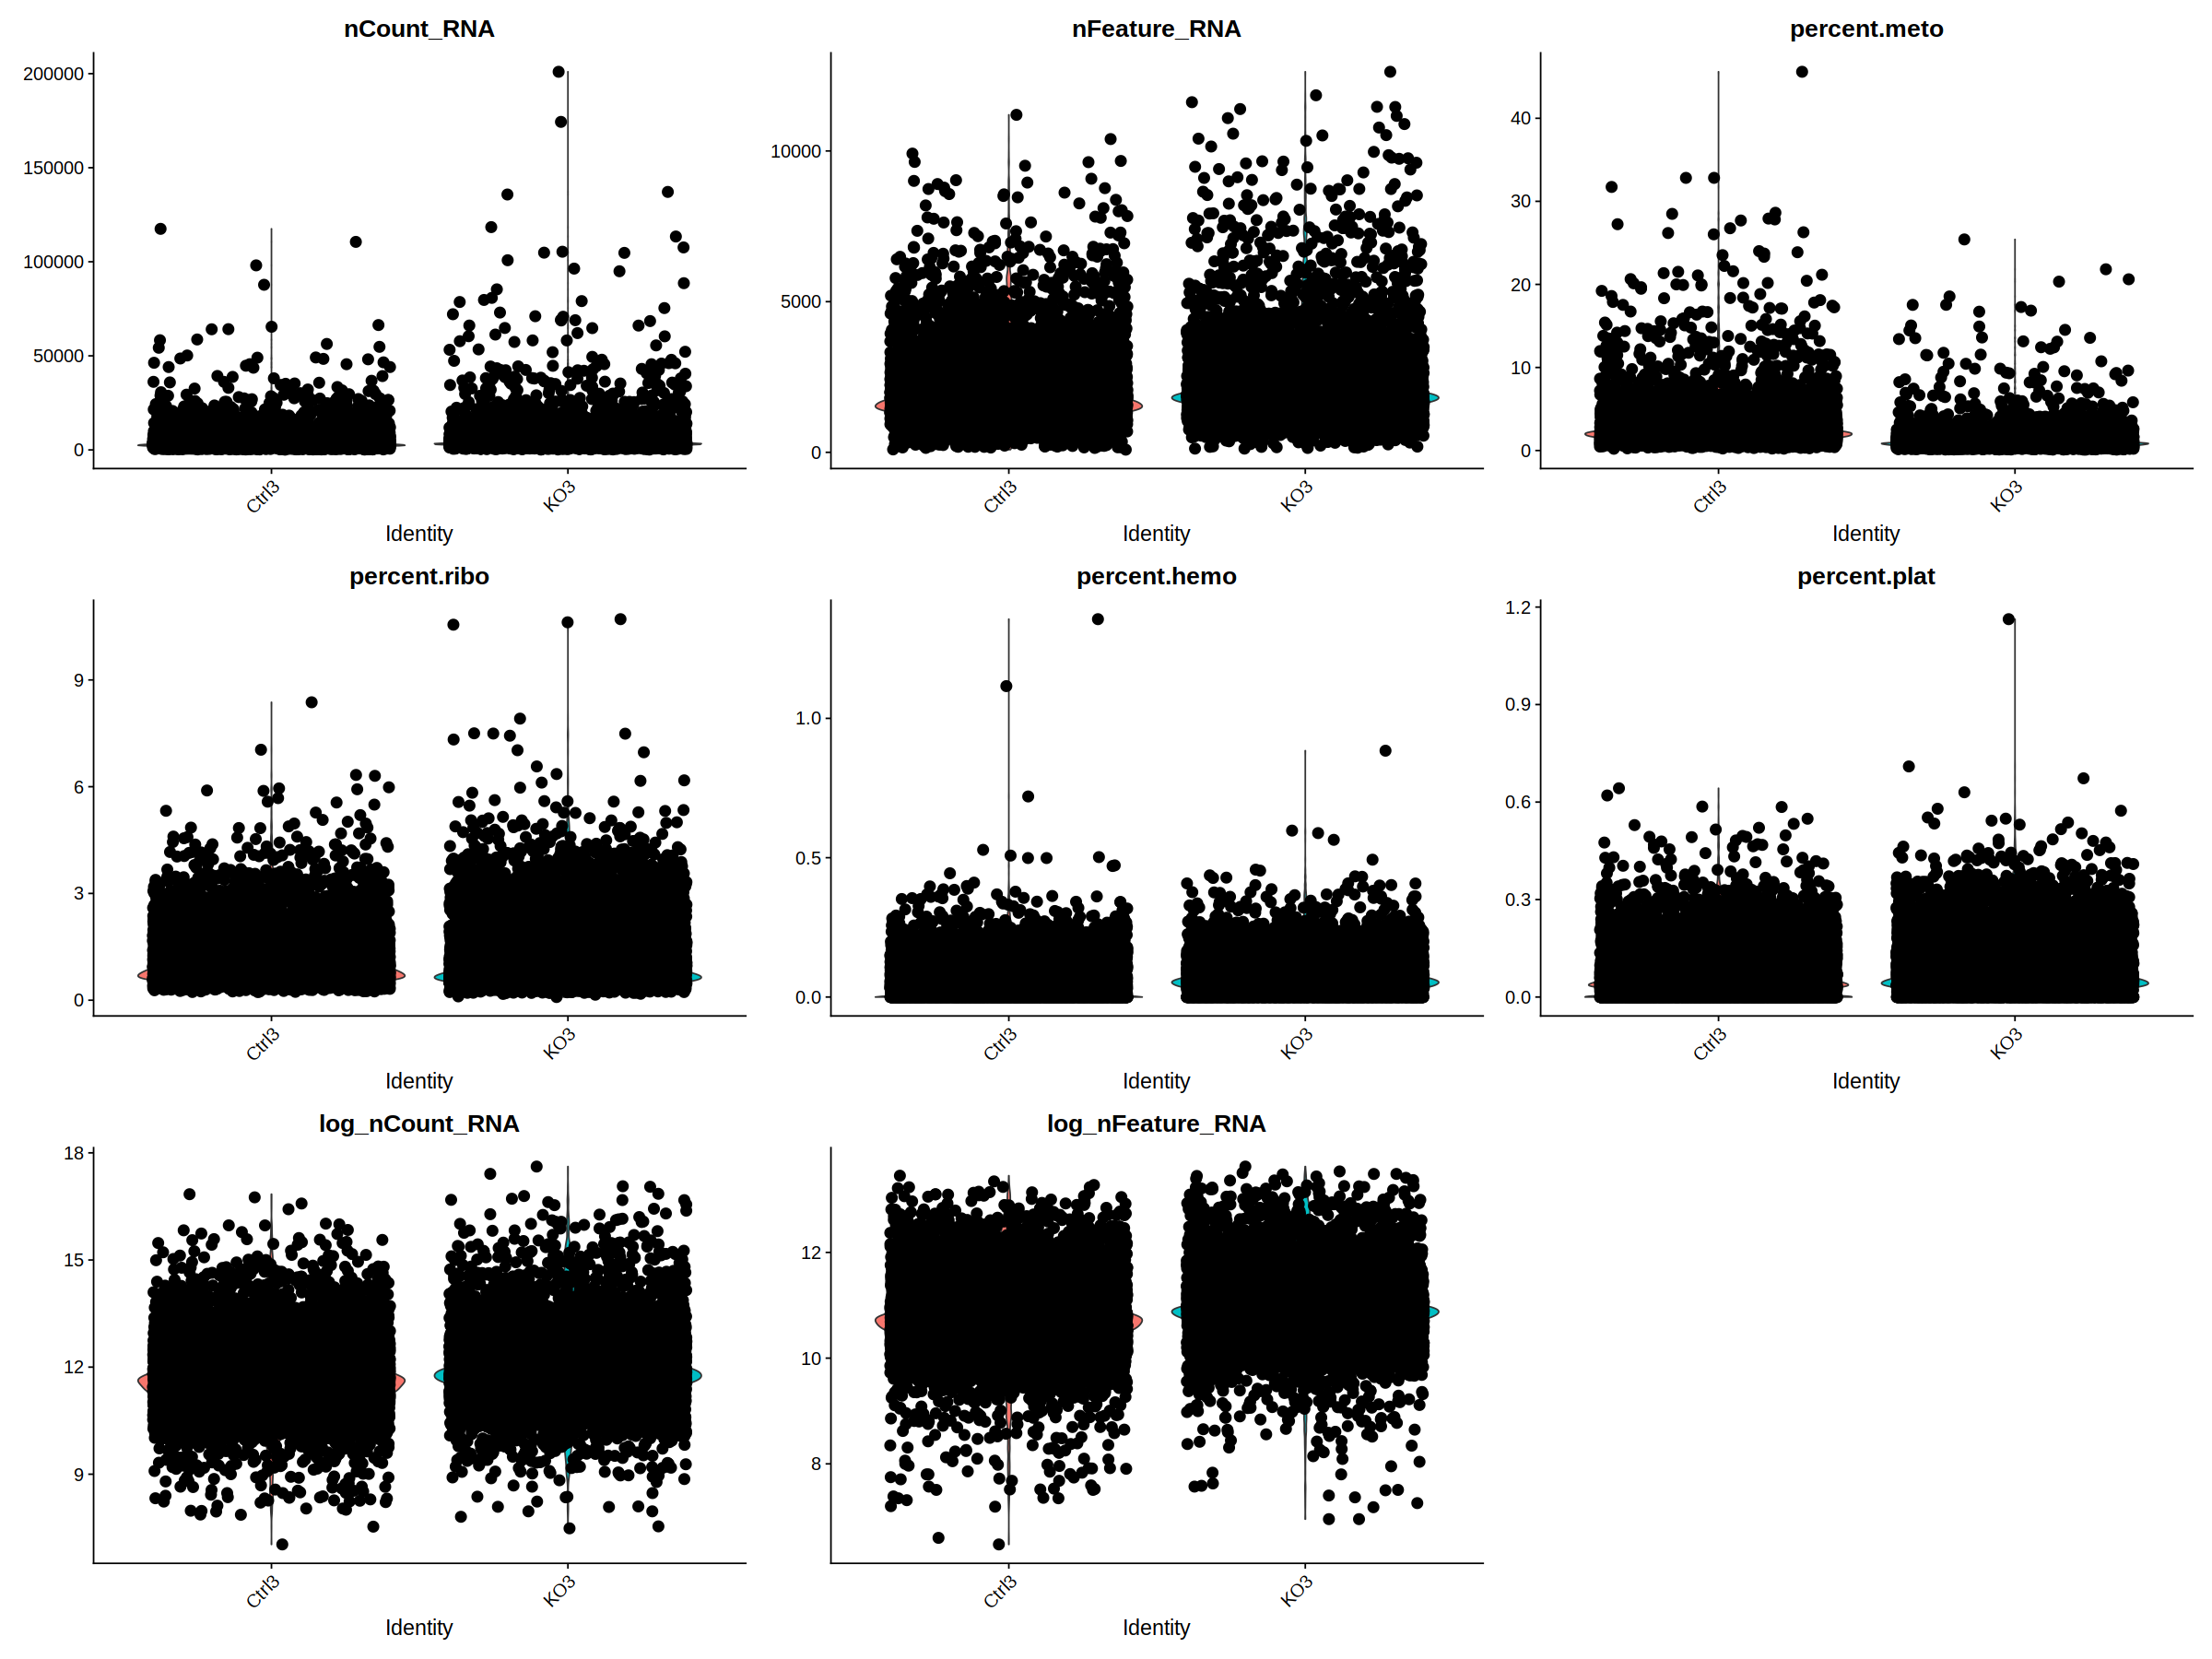

In [94]:
p1

In [95]:
combined[["percent.meto.rate"]] <- combined[["percent.meto"]] >1.5
p2=FeatureScatter(combined, "nCount_RNA", "nFeature_RNA", group.by = "sample", pt.size = 3)+theme_s

In [96]:
# Compute the relative expression of each gene per cell Use sparse matrix
# operations, if your dataset is large, doing matrix devisions the regular way
# will take a very long time.
par(mar = c(4, 8, 2, 1))
C <- combined@assays$RNA@counts
C <- Matrix::t(Matrix::t(C)/Matrix::colSums(C)) * 100
most_expressed <- order(apply(C, 1, median), decreasing = T)[20:1]

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 4.1 GiB”


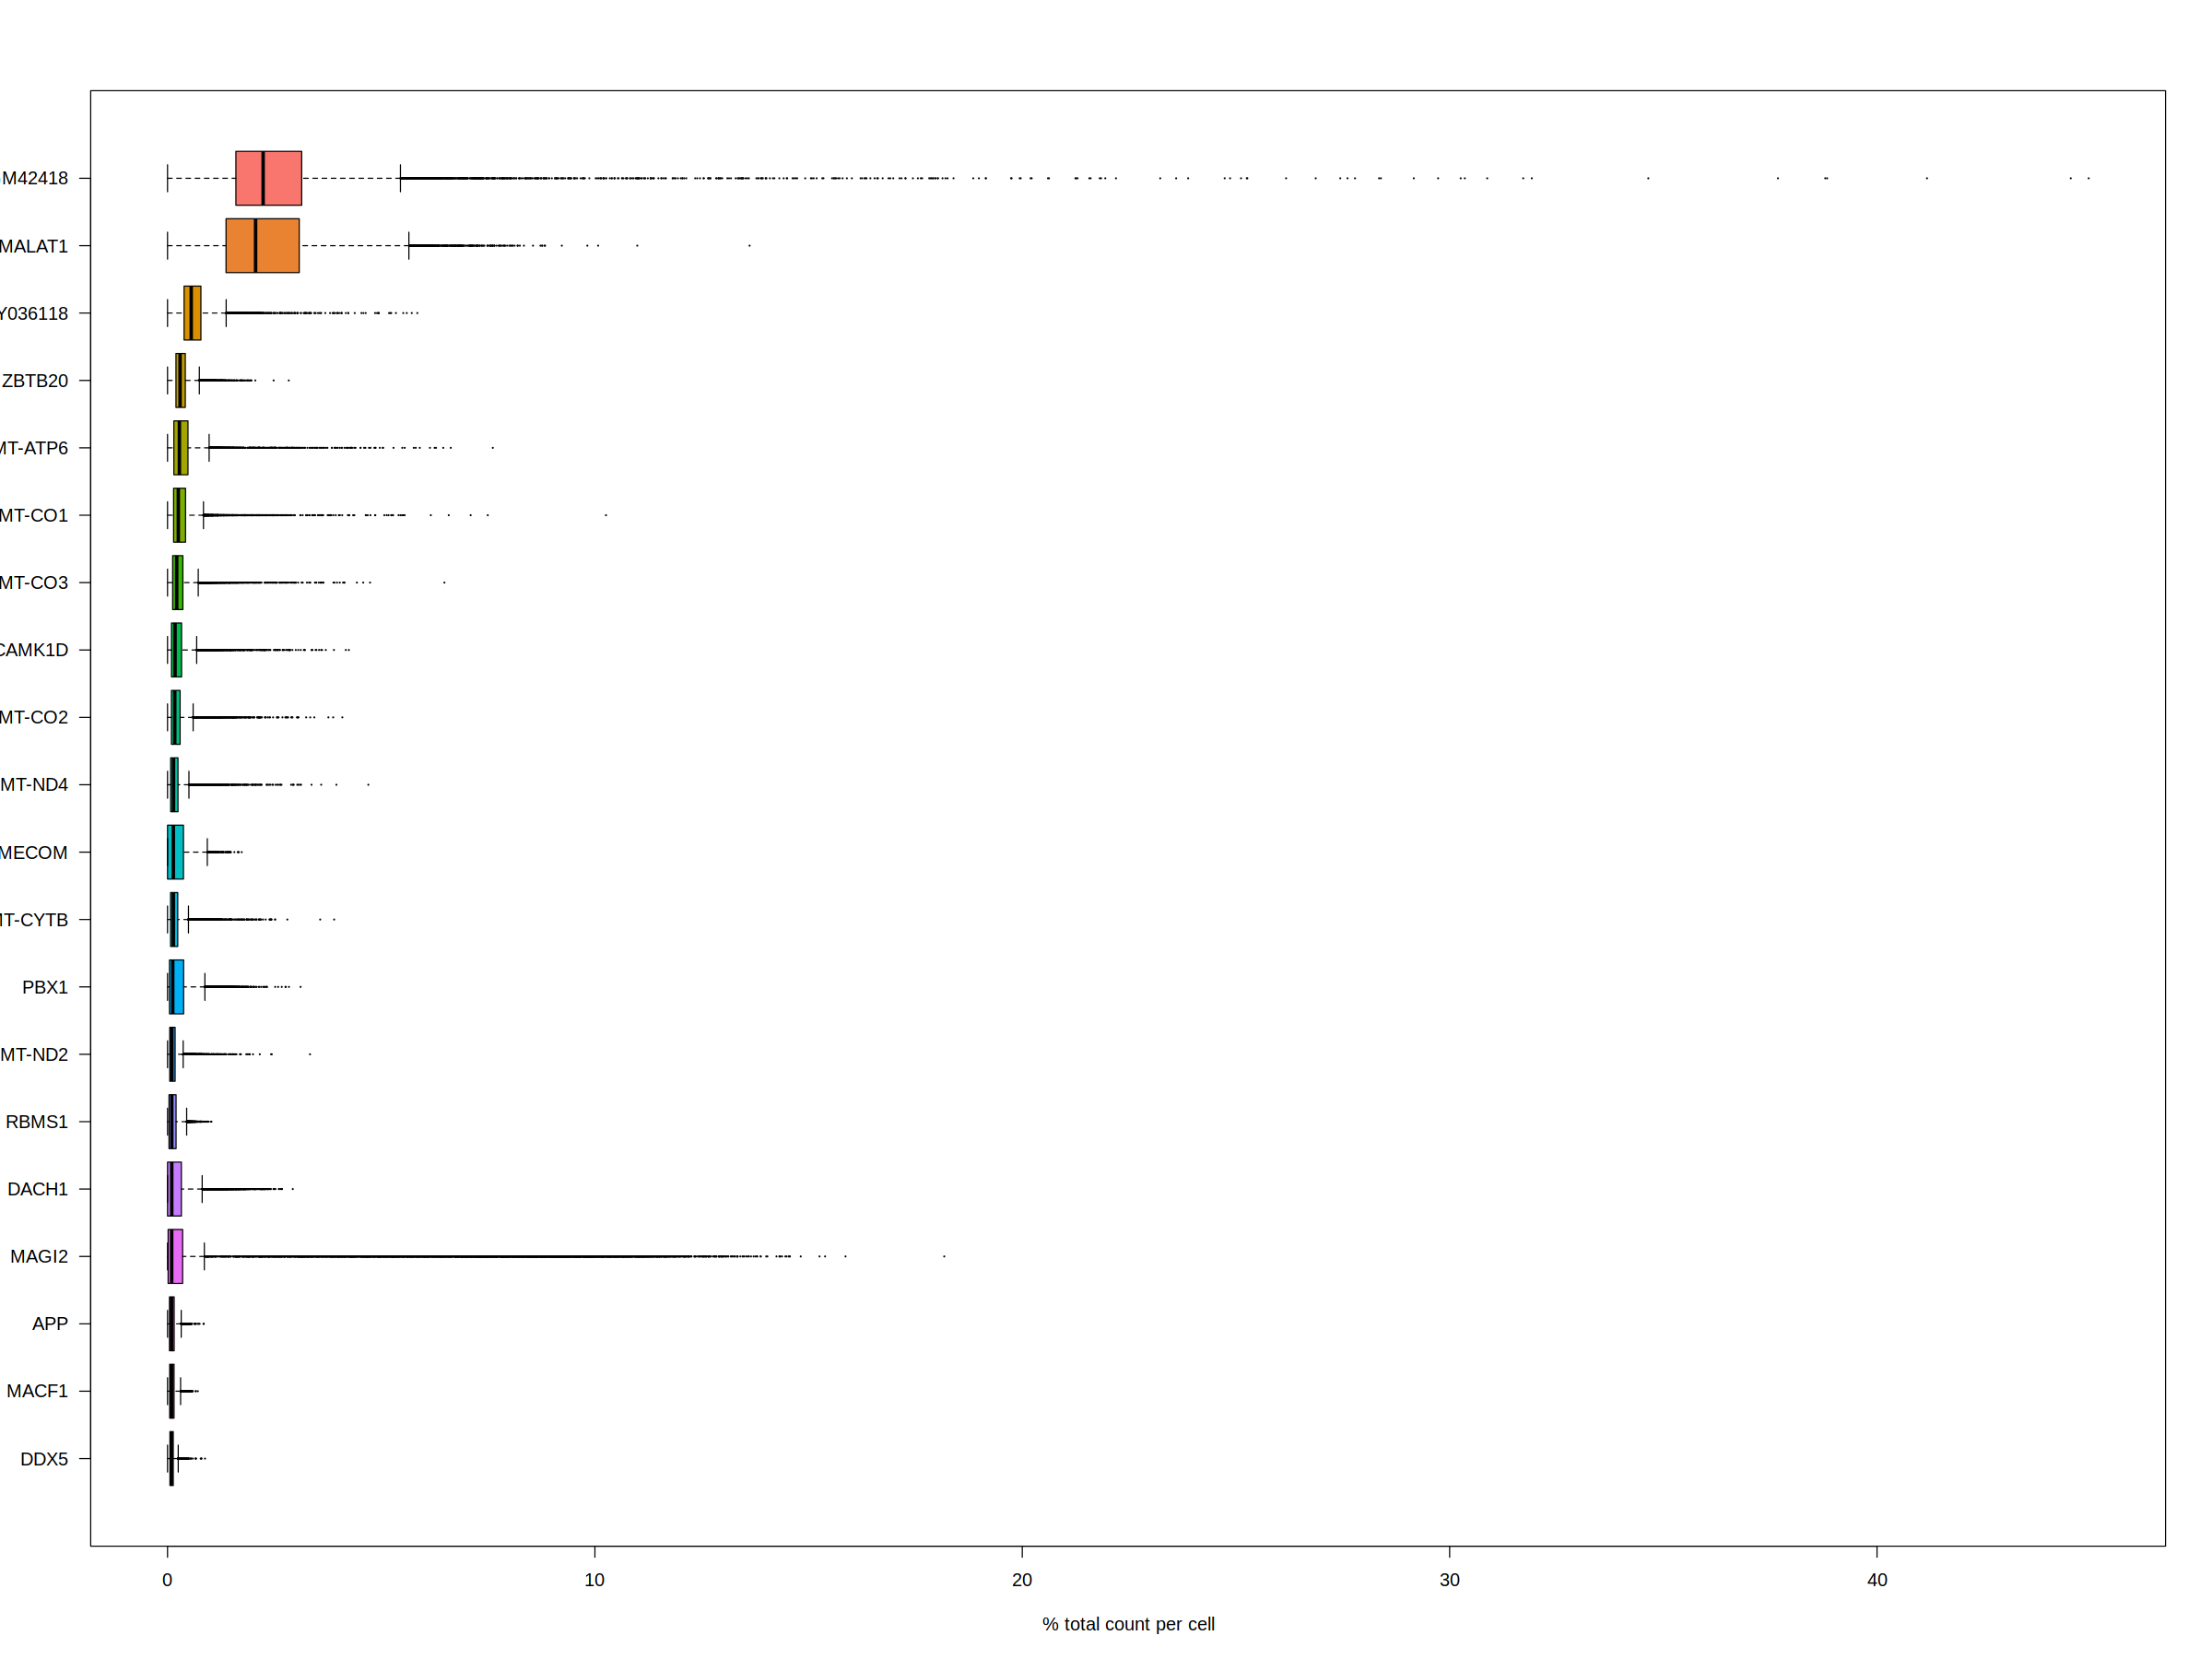

In [97]:
par(cex.main=2.5)
p3=boxplot(t(as.matrix(C[rownames(C)[most_expressed], ])), cex = 0.1, las = 1, xlab = "% total count per cell",
    col = (scales::hue_pal())(20)[20:1], horizontal = TRUE)

# Filter

In [98]:
combined2 <- subset(
  x = combined,
    nCount_RNA < 30000 &
    nFeature_RNA < 10000&
    log_nCount_RNA > 10&
    log_nFeature_RNA > 9.5& 
    percent.meto <5&
    percent.hemo <0.3& 
    percent.ribo <7 &   
    percent.plat <0.4    
    
)


# Plot after Filter

In [99]:
p4 = FeatureScatter(combined2, feature1 = "nCount_RNA", feature2 = "nFeature_RNA", group.by='sample')+theme_s+ 
labs(caption = "After QC")
p3=VlnPlot(
  object = combined2,
  features = c("nCount_RNA","nFeature_RNA","percent.meto","percent.ribo","percent.hemo","percent.plat","log_nCount_RNA","log_nFeature_RNA"),
  ncol = 3,
  pt.size = 3,
  group.by = "sample")+theme_s+labs(caption = "After QC")



In [100]:
freq=cbind(table(combined@meta.data$sample),table(combined2@meta.data$sample))
colnames(freq)= c('RAW','QC')
freq=melt(freq)
colnames(freq)= c('sample','data','value')
p5=ggplot(freq, aes(x = sample, y = value, fill = data)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "# cells before and after QC", x = "Sample", y = "Value") +theme_s

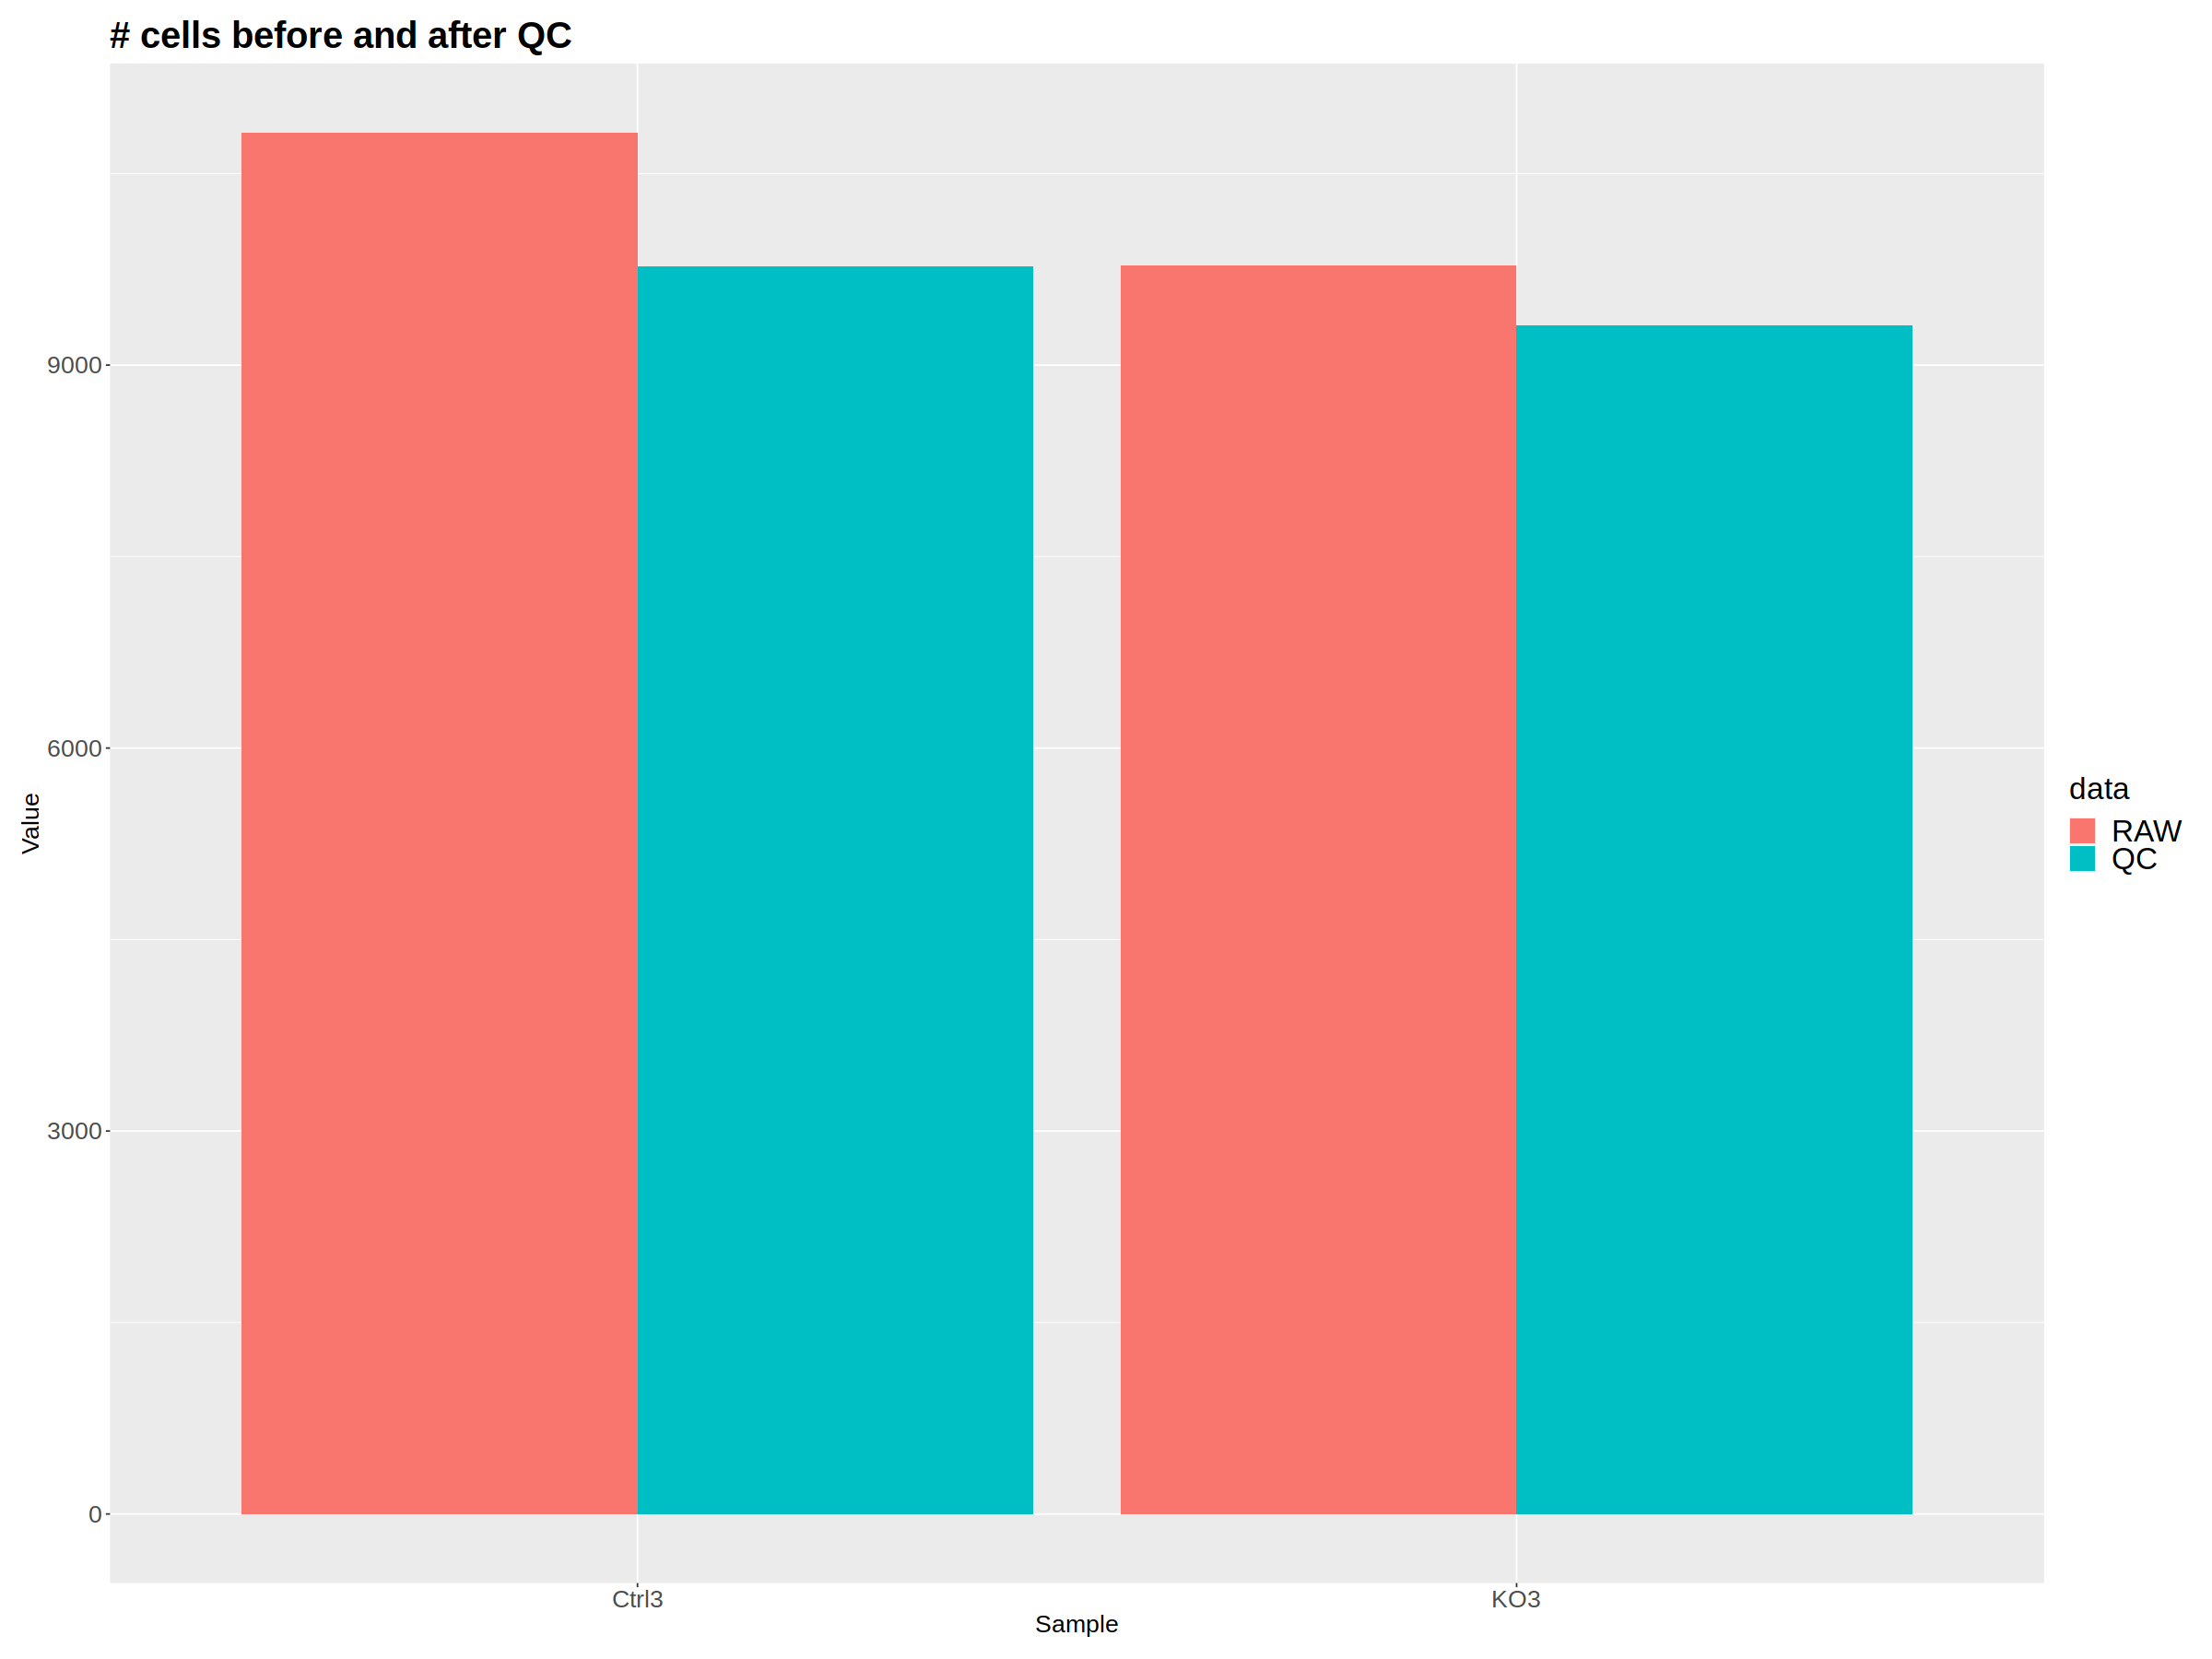

In [101]:
p5

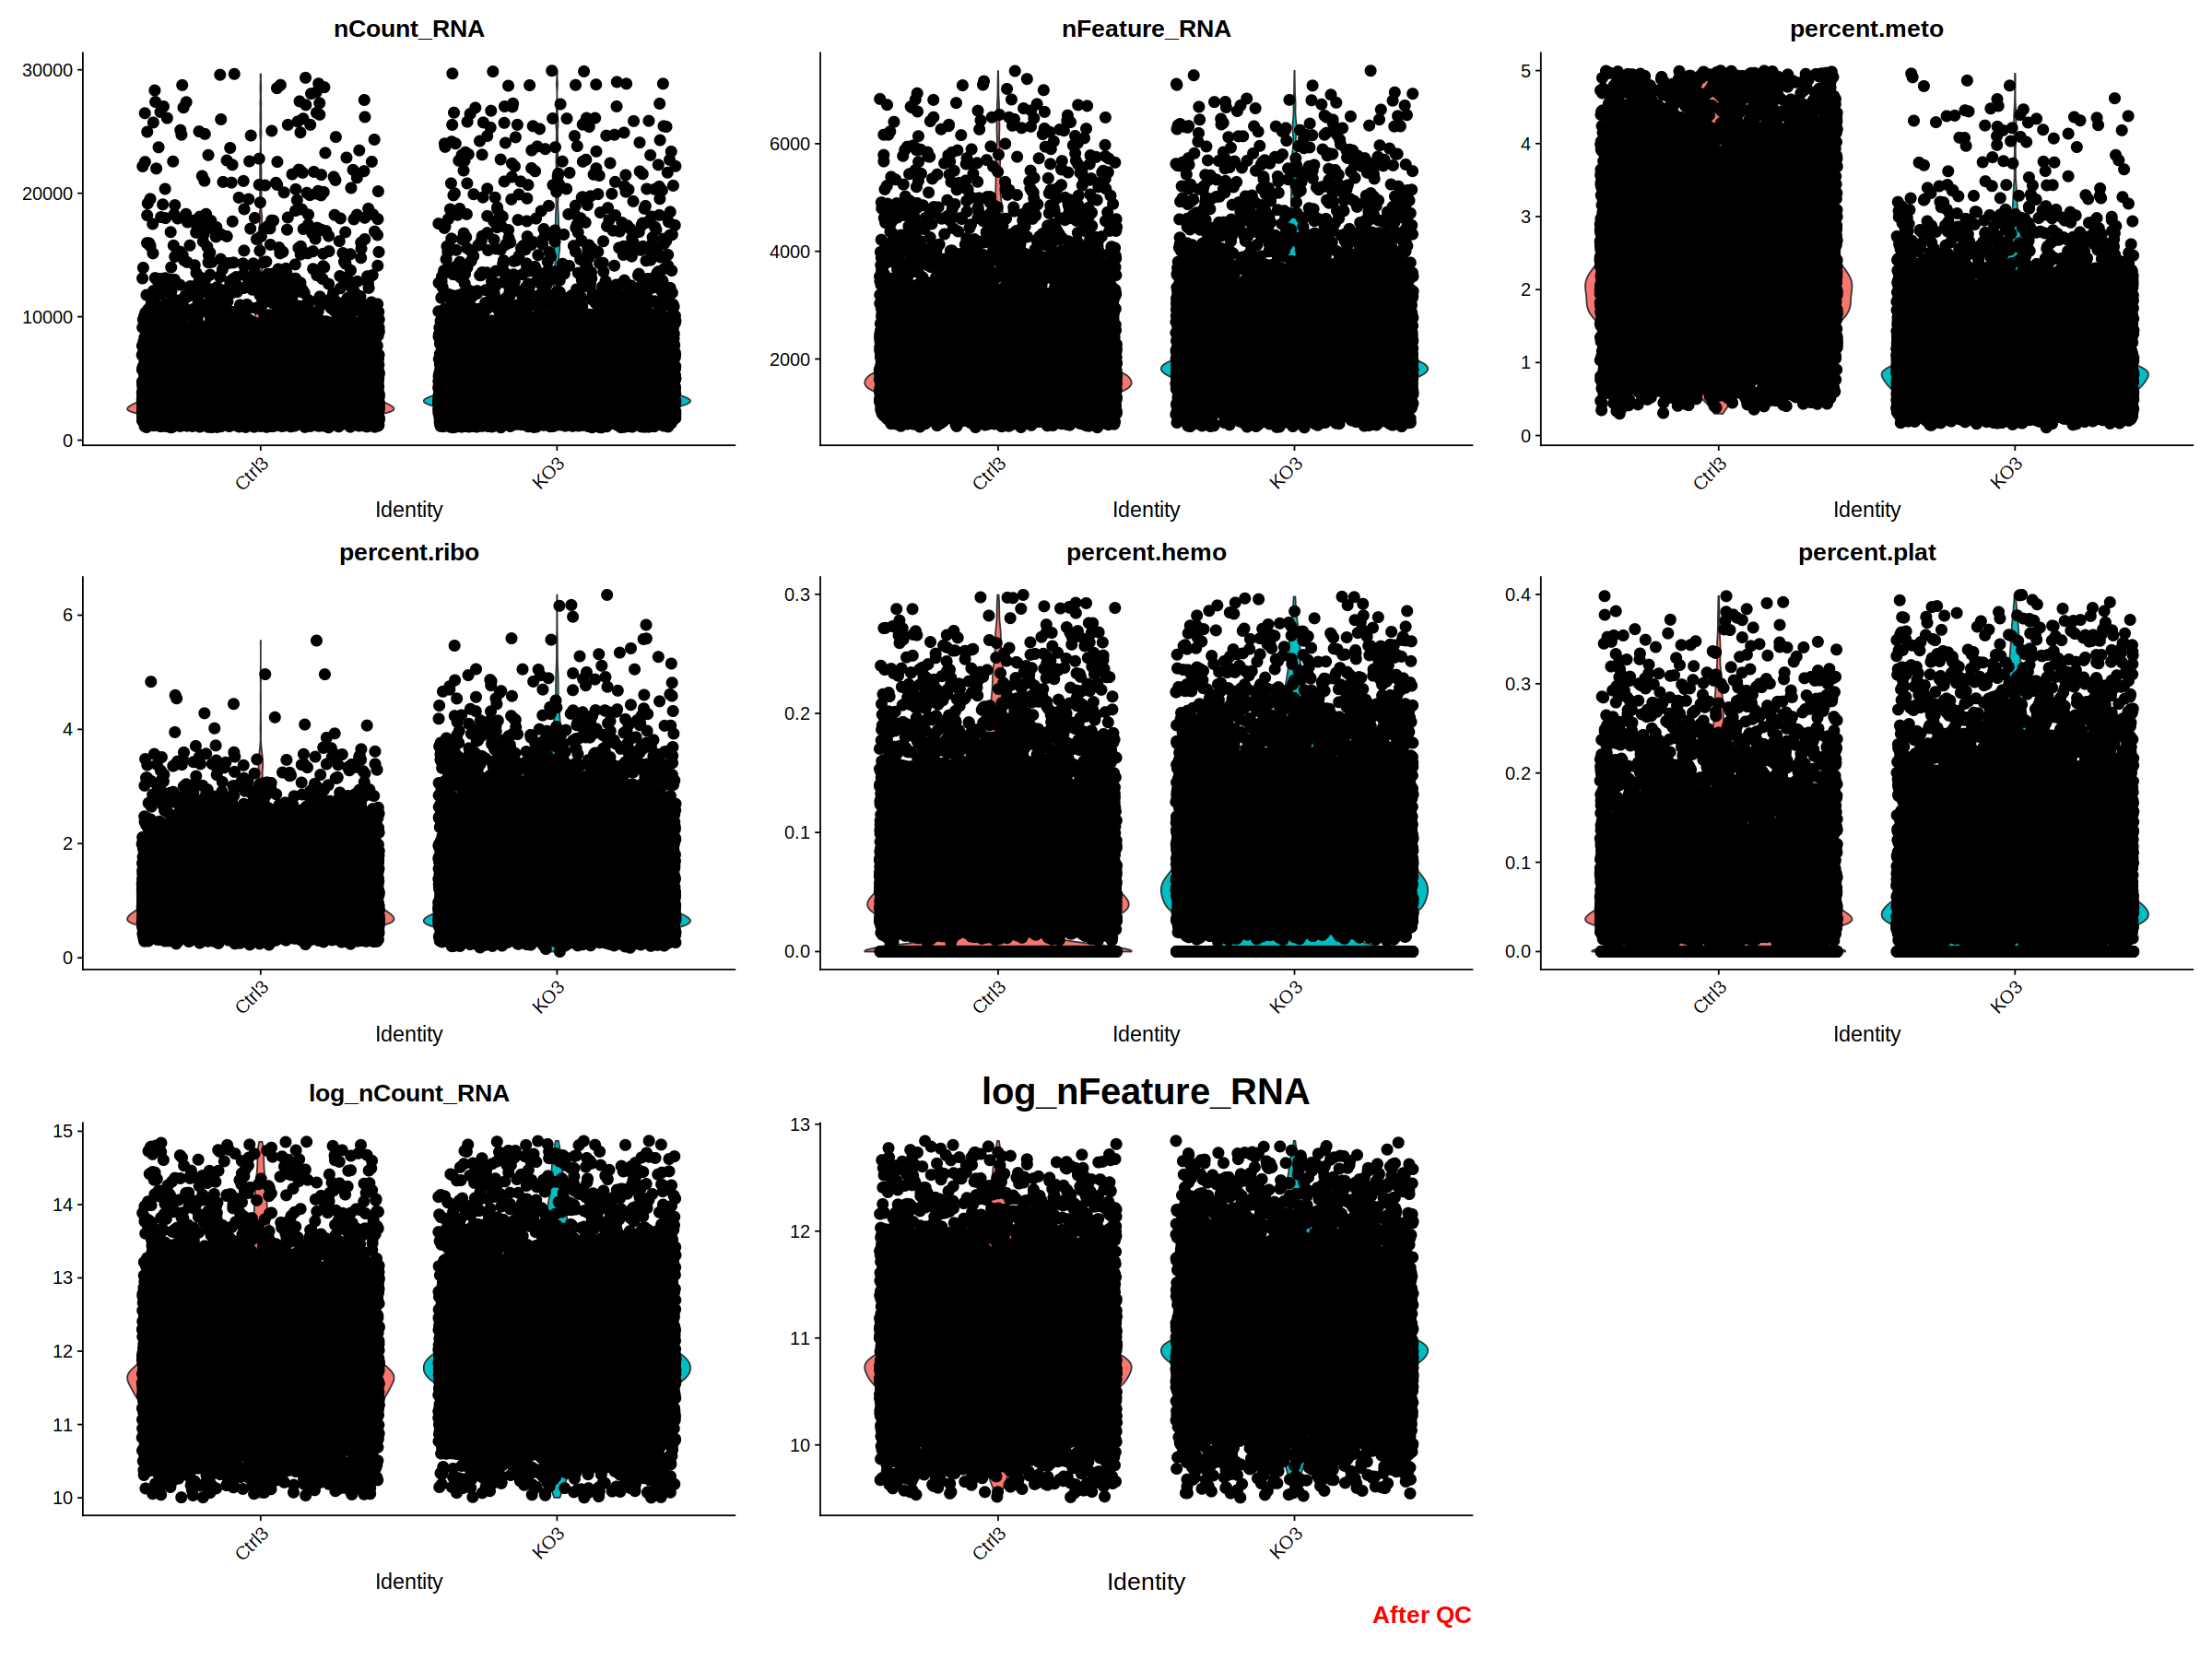

In [102]:
p3

# Process our dataset

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 22216 by 19085

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |======================================================================| 100%


Found 87 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 22216 genes



  |======================================================================| 100%


Computing corrected count matrix for 22216 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 5.5195 mins

Determine variable features

Place corrected count matrix in counts slot

Regressing out percent.meto

Centering data matrix

Set default assay to SCT

PC_ 1 
Positive:  SLC12A3, SLC8A1, FUT9, ABCA13, SLC4A4, PKHD1, ESRRG, SLC34A1, GM42397, SLC5A12 
	   NHS, KCNJ15, PDE4D, WNK1, BNC2, TRPM6, ANK3, SNX29, GHR, GK 
	   SGMS2, DAB2, ERRFI1, LRP2, RHOBTB1, SLC13A1, NDRG1, PHACTR1, FHIT, MECOM 
Negative:  MAGI2, THSD7A, LINGO2, ROBO2, PTPRO, SRGAP1, PARD3B, OPCML, NPHS2, ZFP385B 
	   WT1, ARHGAP28, ASTN2, TDRD5, DACH1, NEBL, DPP4, PLCE1, GM29266, SGIP1 
	   SEMA3E, ALCAM, C1QTNF7, PODXL, IQGAP2, NPHS1, SYNPO, GABRB1, DOCK4, NTRK3 
PC_ 2 
Positive:  MEIS2, EMCN, HECW2, CALCRL, PLPP1, CHRM3, EPHA6, IGFBP5, DLC1, NRP1 
	   DKK2, LDB2, PBX1, PTPRB, EHD3, KDR, EBF1, CYYR1, ADGRL4, PRKG1 
	   PTPRG, FLT1, HEG1, PREX2, DGKB, FAM117B, CTNNA3, PLAT, PTPRM, ADAMTS5 
Negative:  SLC12A3, MAGI2, SLC8A1, FUT9, ABCA13, PKHD1, 

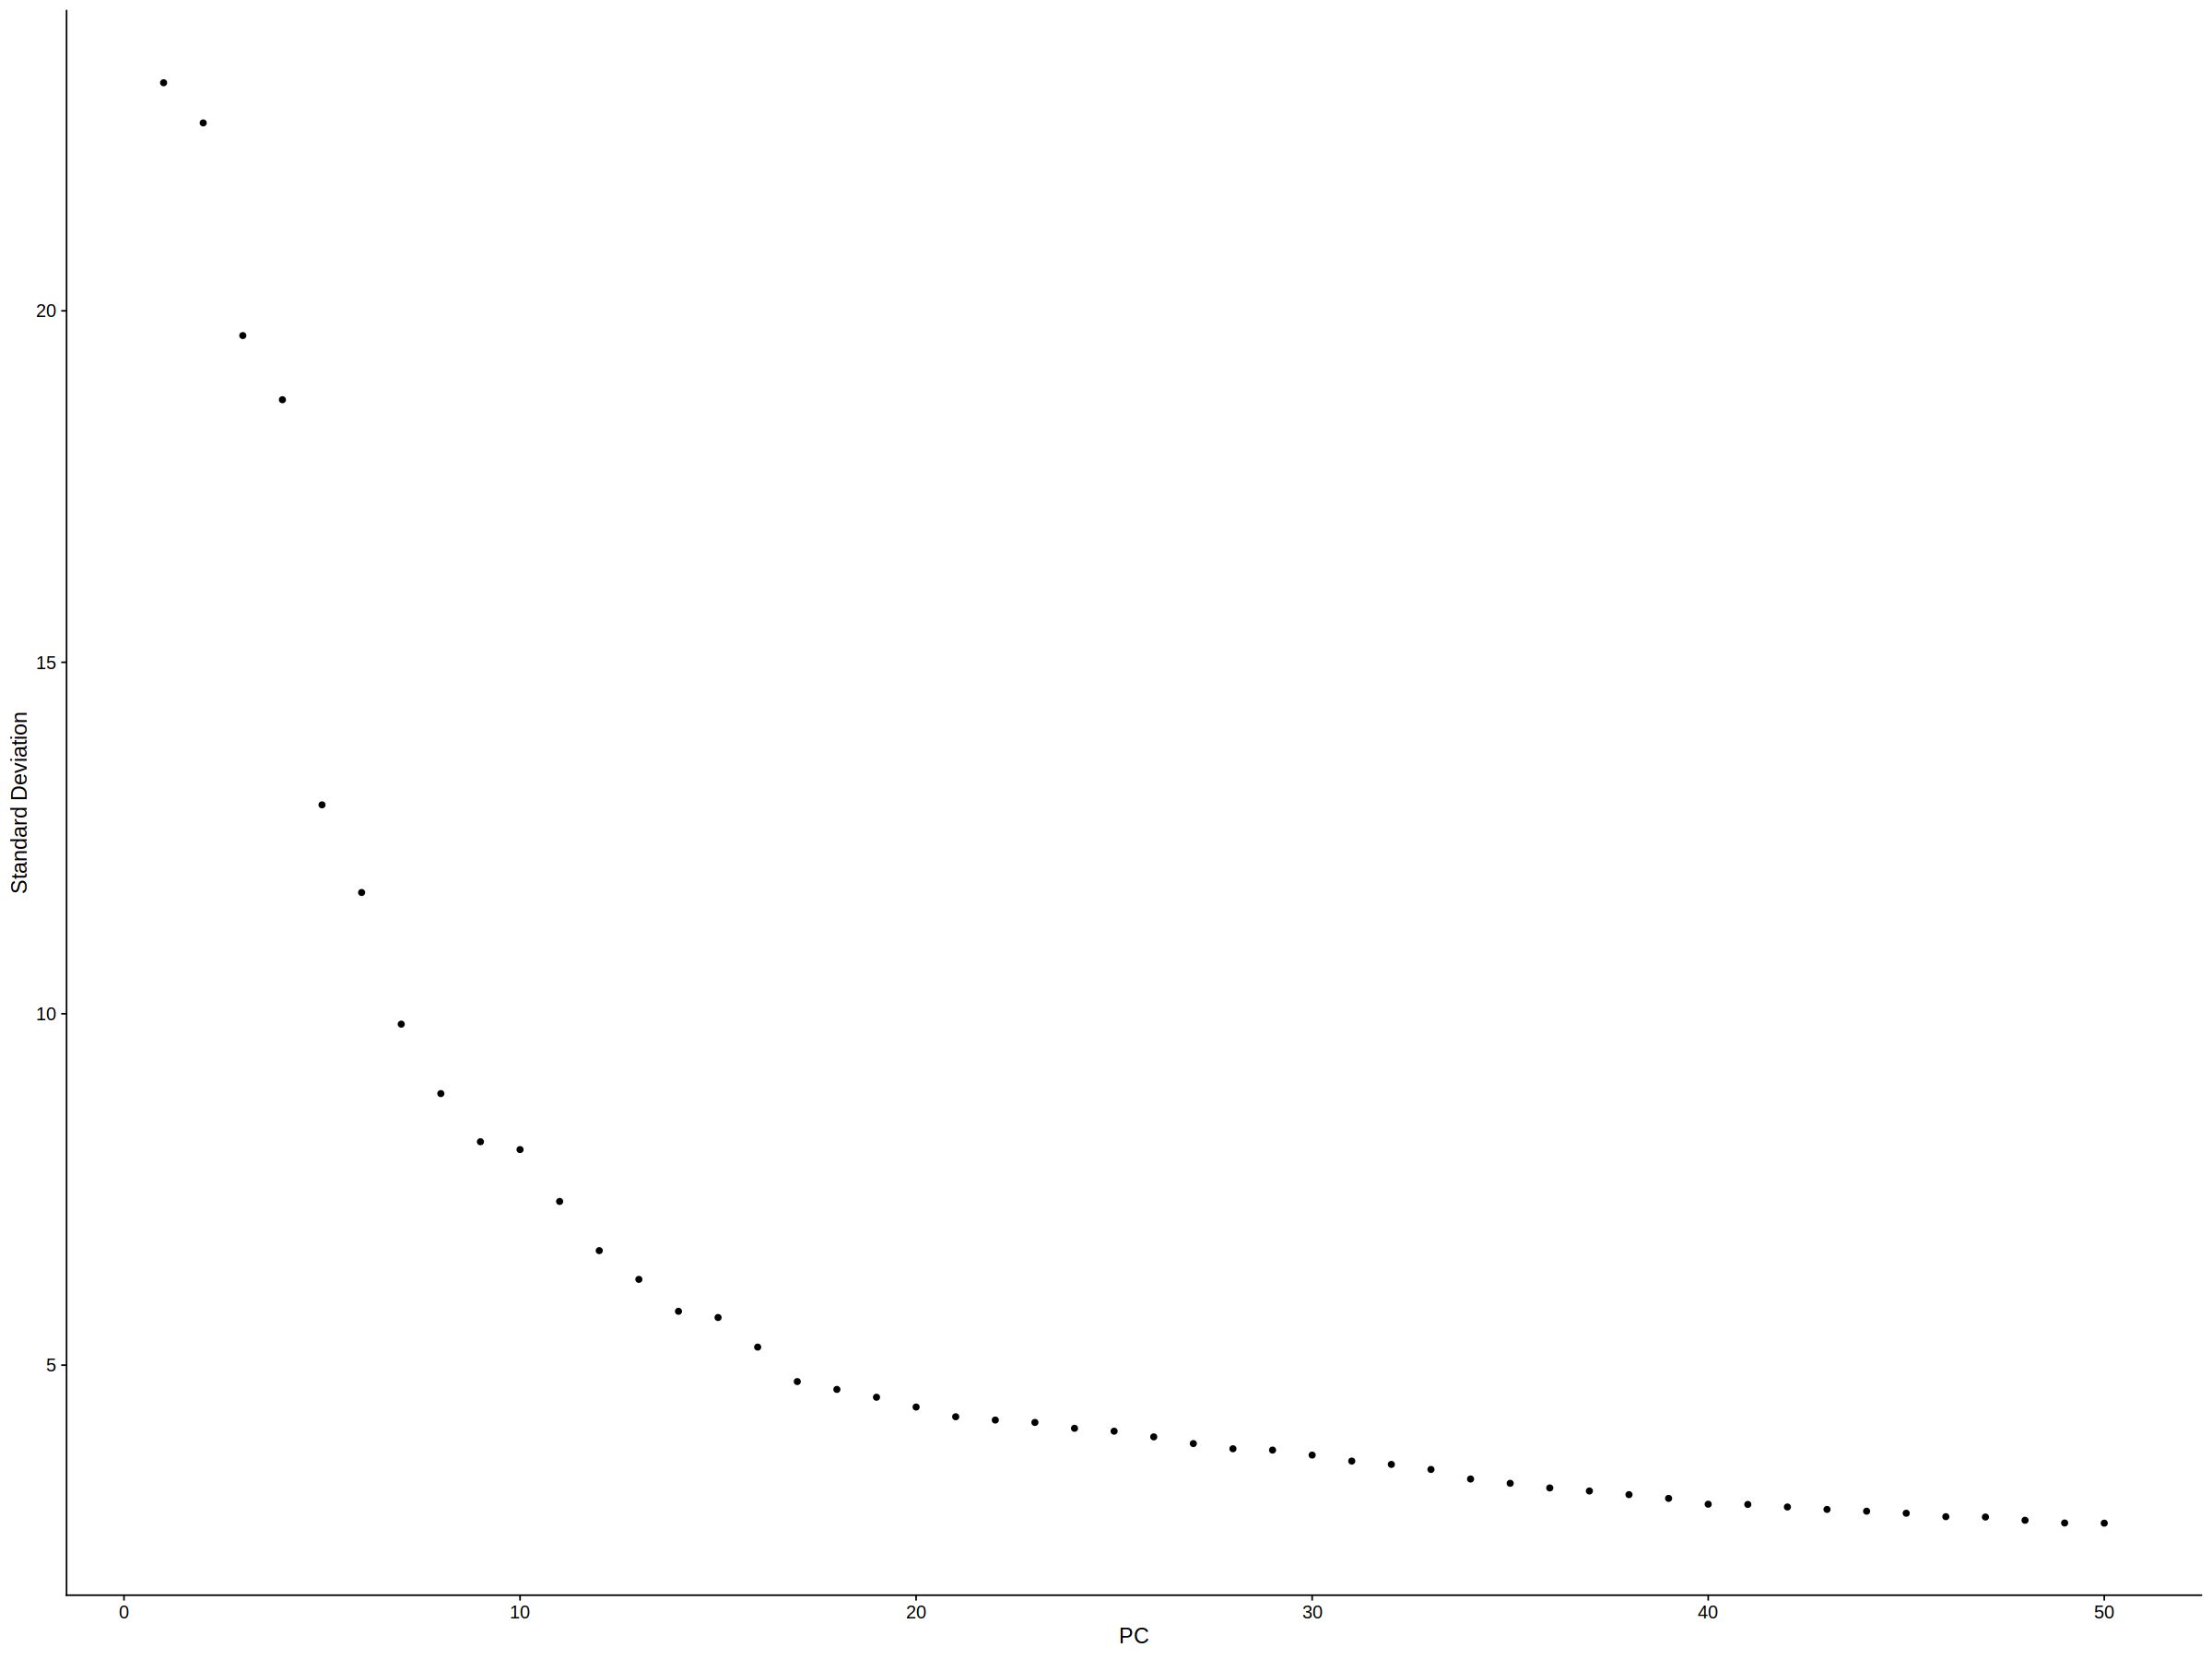

In [103]:
combined2<-SCTransform(combined2, vars.to.regress = "percent.meto")
combined2 <- RunPCA(combined2)
ElbowPlot(combined2, ndims = 50)
combined2 <- RunUMAP(combined2, dims = 1:50,umap.method = "uwot",return.model = TRUE)

In [104]:
combined2 <- FindNeighbors(combined2, dims = 1:50, reduction= "pca")
combined2 <- FindClusters(combined2, resolution = 0.3, reduction= "pca")
unique(Idents(combined2))

Computing nearest neighbor graph

Computing SNN

Warning message:
“The following arguments are not used: reduction”
Warning message:
“The following arguments are not used: reduction”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 19085
Number of edges: 686631

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9564
Number of communities: 19
Elapsed time: 2 seconds


[1] 2  4  6  1  7  3  5  8  11 13 0  16 12 15 10 14 17 18 9 
Levels: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18

In [105]:

# cluster2.markers <- FindAllMarkers(object = combined2,assay = "SCT",
#                                                  only.pos = TRUE,
#                                                  min.pct = 0.2,
#                                                  logfc.threshold = 0.2,
#                                                  min.diff.pct = 0.1,
#                                                  test.use = "wilcox"
# )


In [106]:
# markers=cluster2.markers %>%
#     group_by(cluster) %>%
#     slice_max(n = 10, order_by = abs(avg_log2FC))

# # 0 endo, 1: podo, 2: tub, 3: tub, 4: Mesangial, 5: Endothelial, 6: tub/Limb/endo 7:immun, 8:muscle, 9:endo 

In [107]:
combined2$celltype_level2= as.character(combined2$`SCT_snn_res.0.3`)
combined2$celltype_level2[combined2$celltype_level2 %in% c(2,10)]= 'Podocytes'
combined2$celltype_level2[combined2$celltype_level2 %in% c(0,4,7,18)]='Endothelium'
# combined2$celltype_level2[combined2$celltype_level2 %in% c(6,9,12,25,26,19,18,23)]=6
combined2$celltype_level2[combined2$celltype_level2 %in% c(1,5,6,12,15,16,9,13,8)]='Connecting Tubule'
# combined2$celltype_level2[combined2$celltype_level2 %in% c(6,9,10)]= 'Distal Convoluted Tubule'
# combined2$celltype_level2[combined2$celltype_level2 %in% c(12,16)]='Proximal Tubule Epithelial'
# combined2$celltype_level2[combined2$celltype_level2 %in% c(2,15)]='Smooth Muscle'
combined2$celltype_level2[combined2$celltype_level2 %in% c(3)]='Undefined'

# combined2$celltype_level2[combined2$celltype_level2 %in% c(6,9,12,25,26,19,18,23)]=6

# combined2$celltype_level2[combined2$celltype_level2 %in% c(10,15,16,2)]=10
# combined2$celltype_level2[combined2$celltype_level2 =='20']='Undefined2'
combined2$celltype_level2[combined2$celltype_level2 == '14']='Podo+Endo'
combined2$celltype_level2[combined2$celltype_level2 == '17']='Mesangium'
combined2$celltype_level2[combined2$celltype_level2 == '11']='Immune'


Idents(combined2)=combined2$celltype_level2
# 'Endothelium','Podocytes','Mesangium','Tubules','Immune'

In [108]:
combined2$celltype_level1 = combined2$celltype_level2
combined2$celltype_level1[combined2$celltype_level1 %in% c('Proximal Tubule Epithelial'
                                                           ,'Distal Convoluted Tubule',
                                                          'Connecting Tubule')]='Tubules'
combined2$celltype_level1[combined2$celltype_level1 %in% c('Undefined'
                                                           ,'Undefined2')]='Undefined'
Idents(combined2)=combined2$celltype_level1


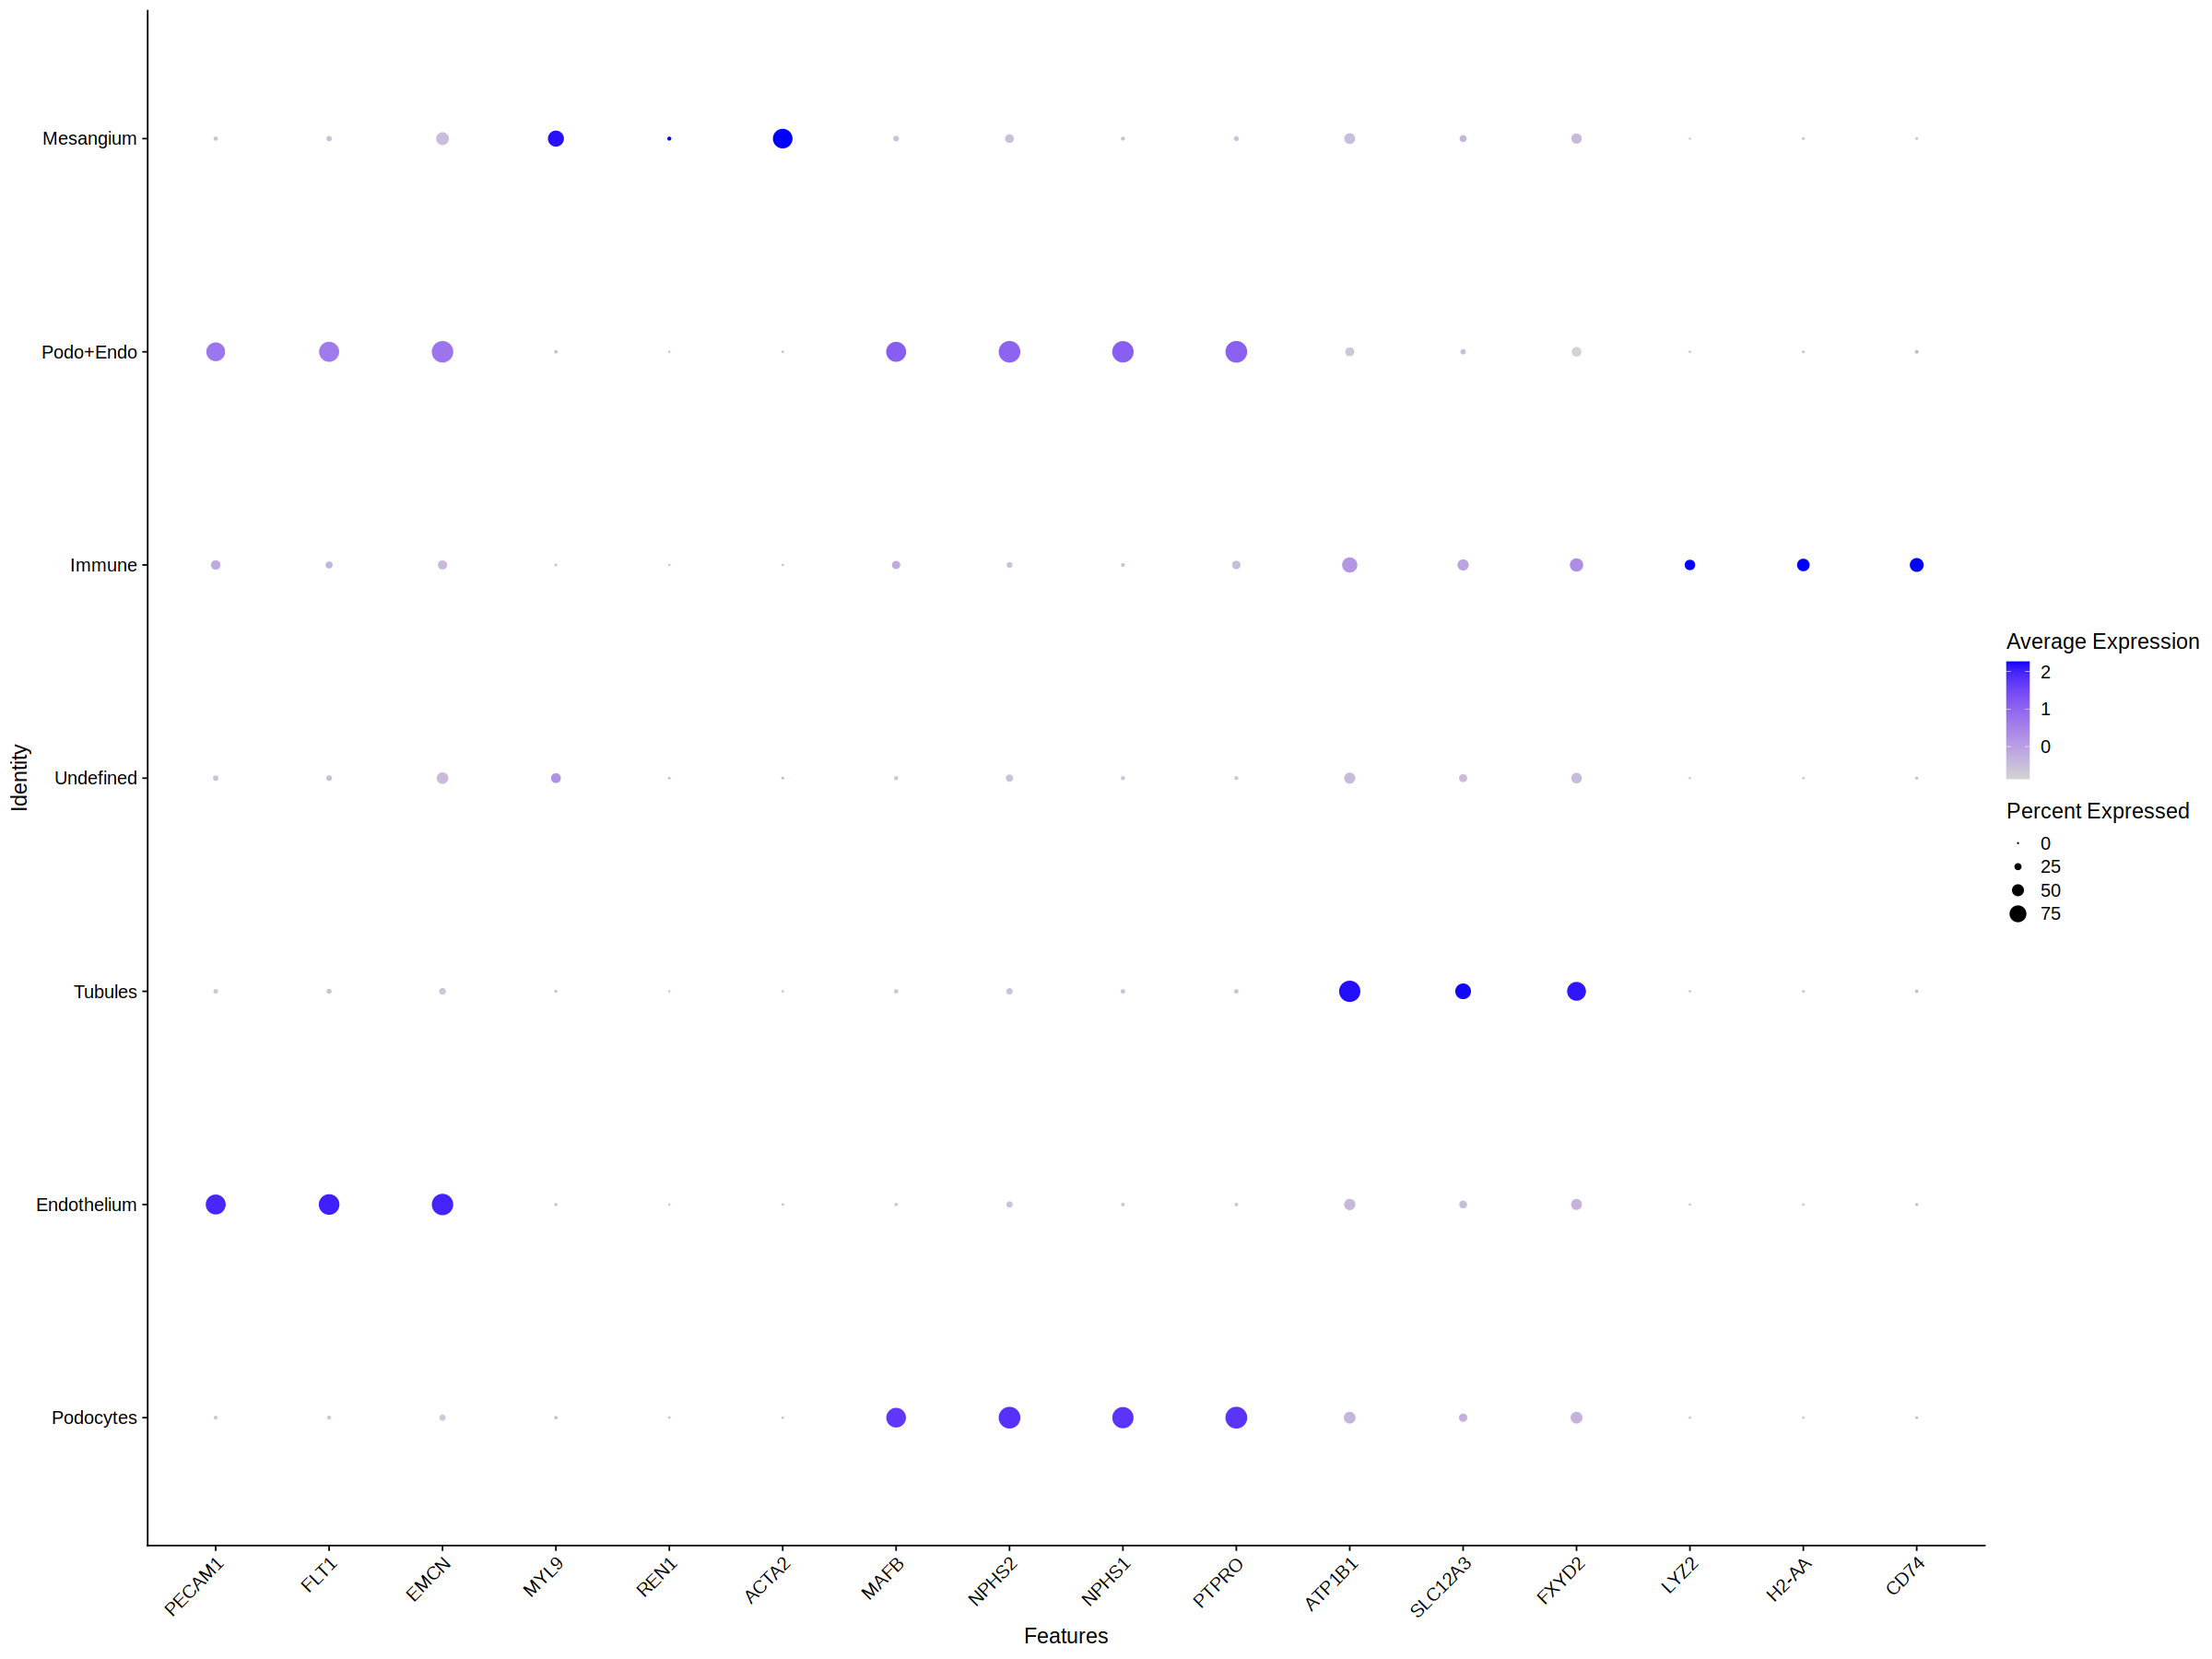

In [109]:
p6 = DotPlot(combined2,  features = c('PECAM1','FLT1','EMCN','MYL9','REN1','ACTA2','MAFB','NPHS2','NPHS1'
                                ,'PTPRO','ATP1B1','SLC12A3','FXYD2','LYZ2','H2-AA','CD74')) + RotatedAxis()
p6

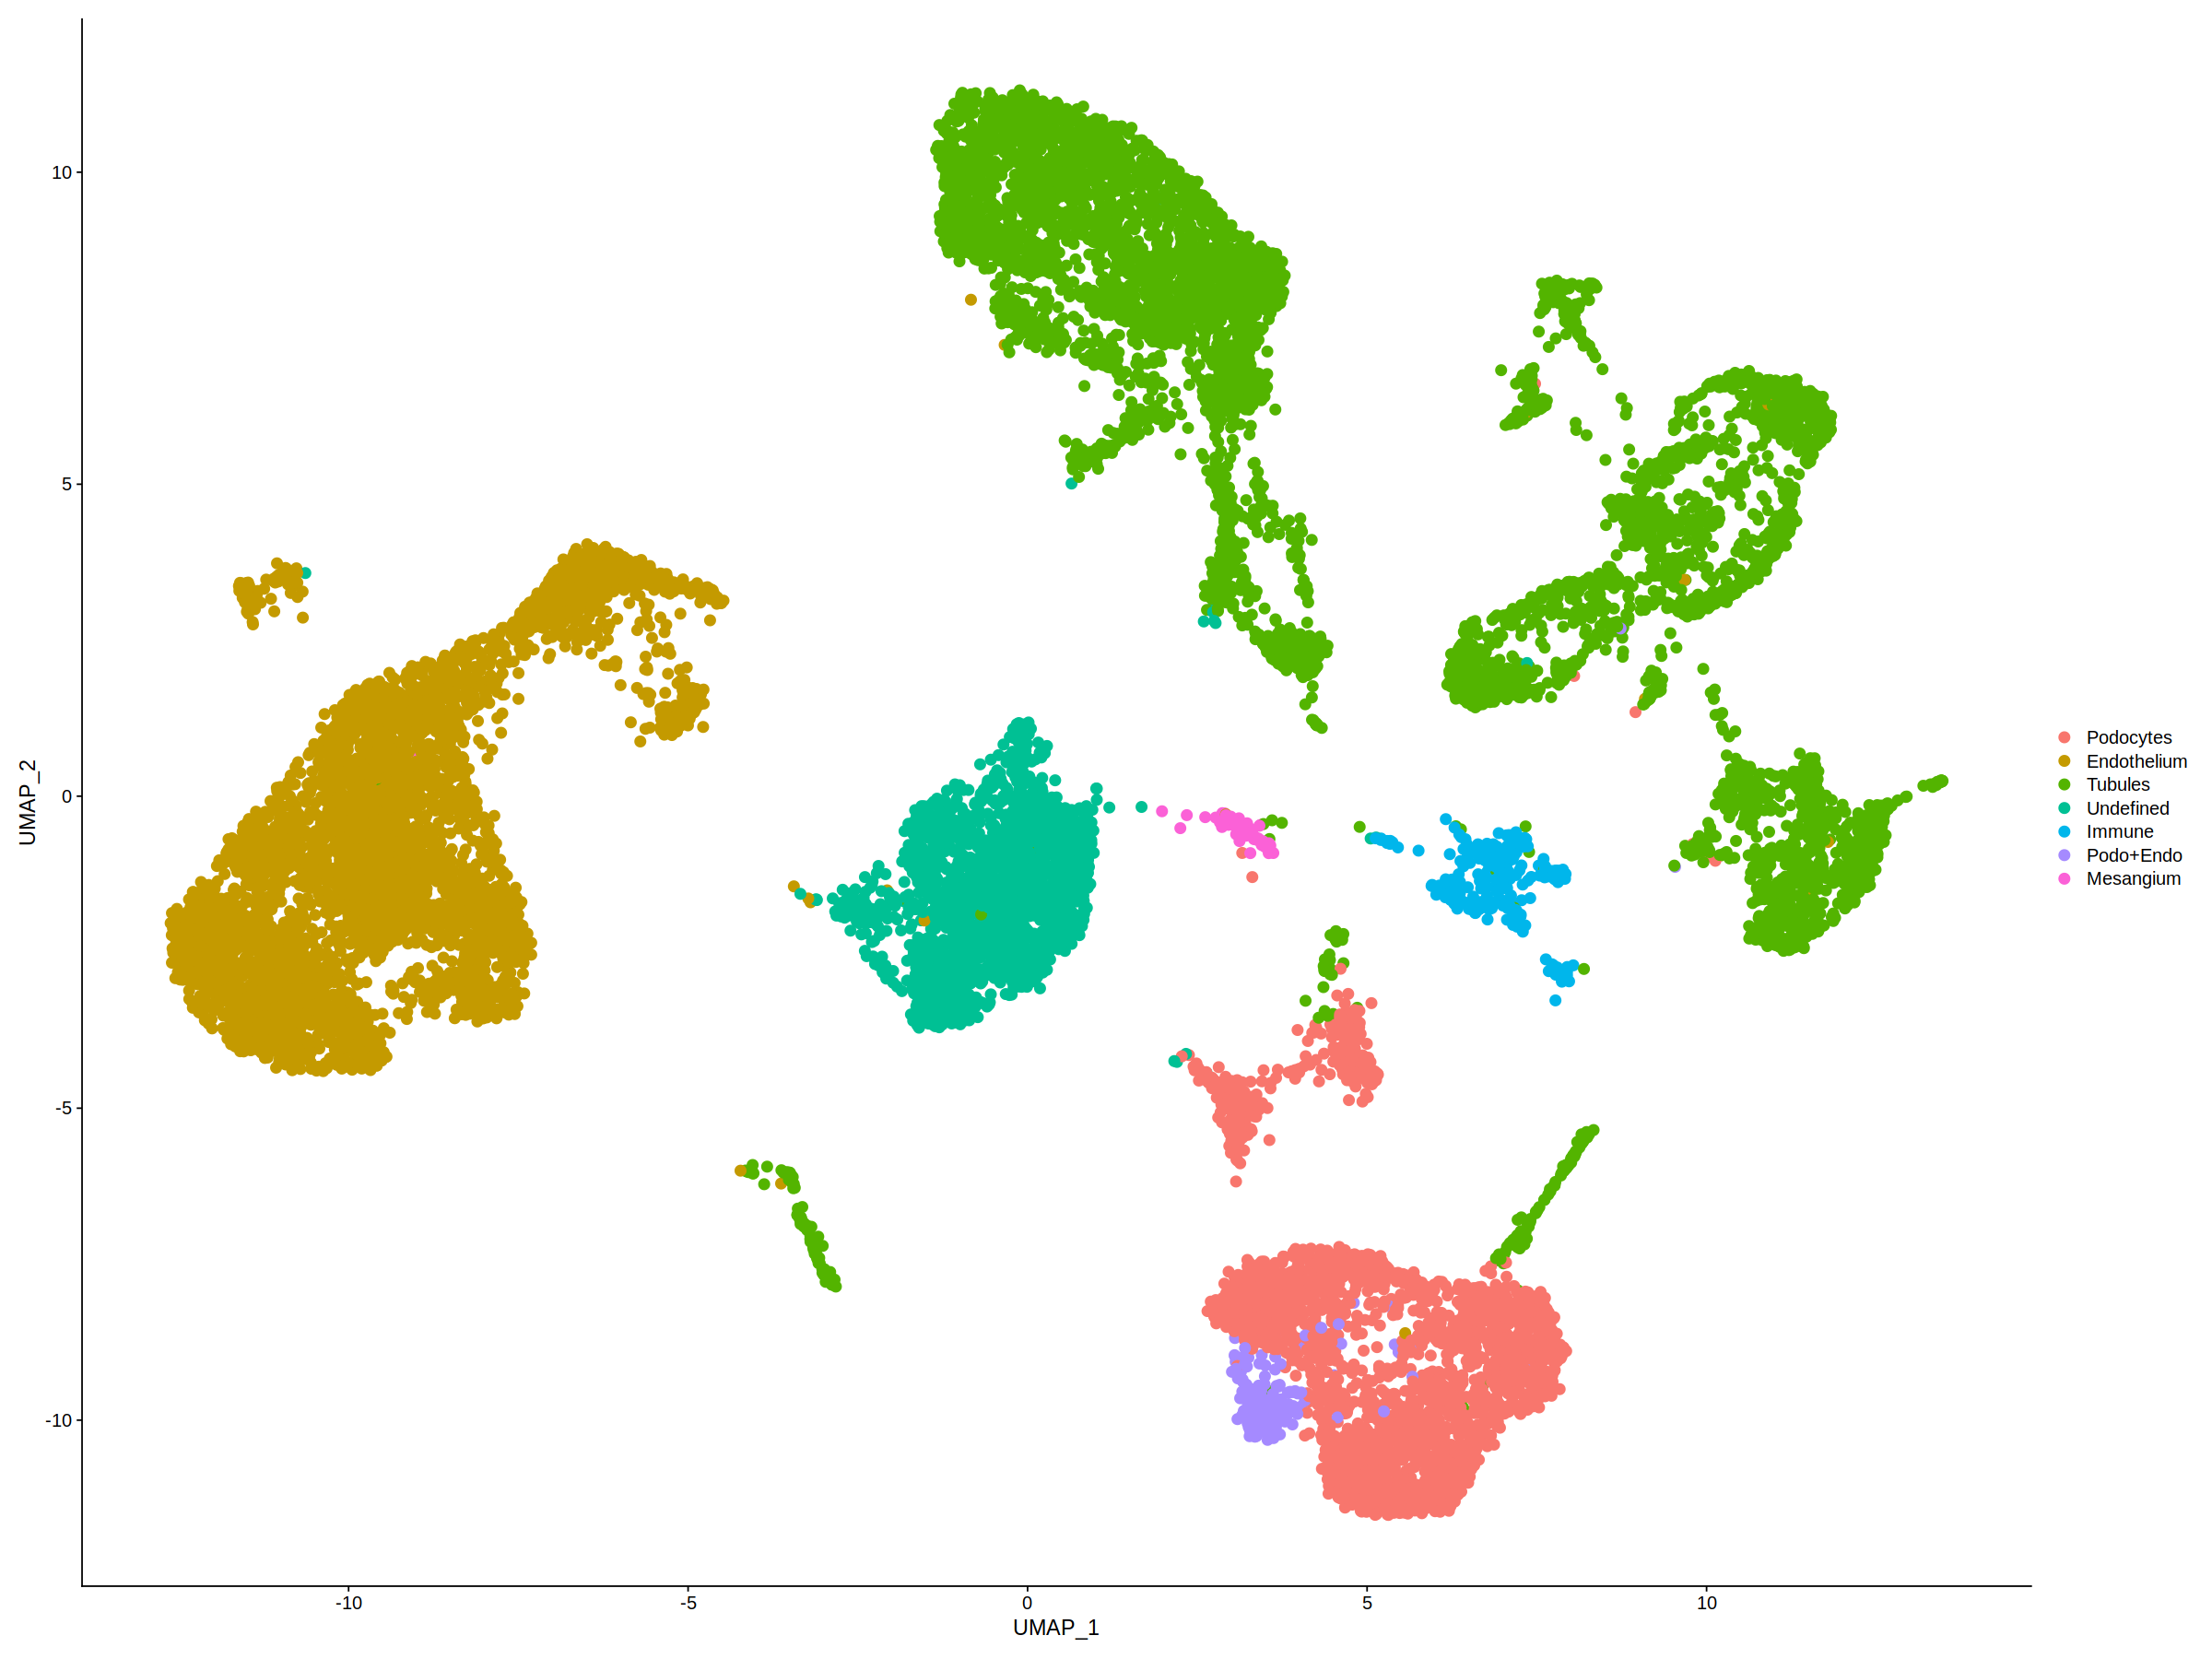

In [110]:
p7= DimPlot(combined2,reduction = "umap",  repel = TRUE,pt.size = 3)
#p2= DimPlot(combined2, reduction = "umap",group.by ='predicted.id' ,  repel = TRUE,pt.size = 3)
p7

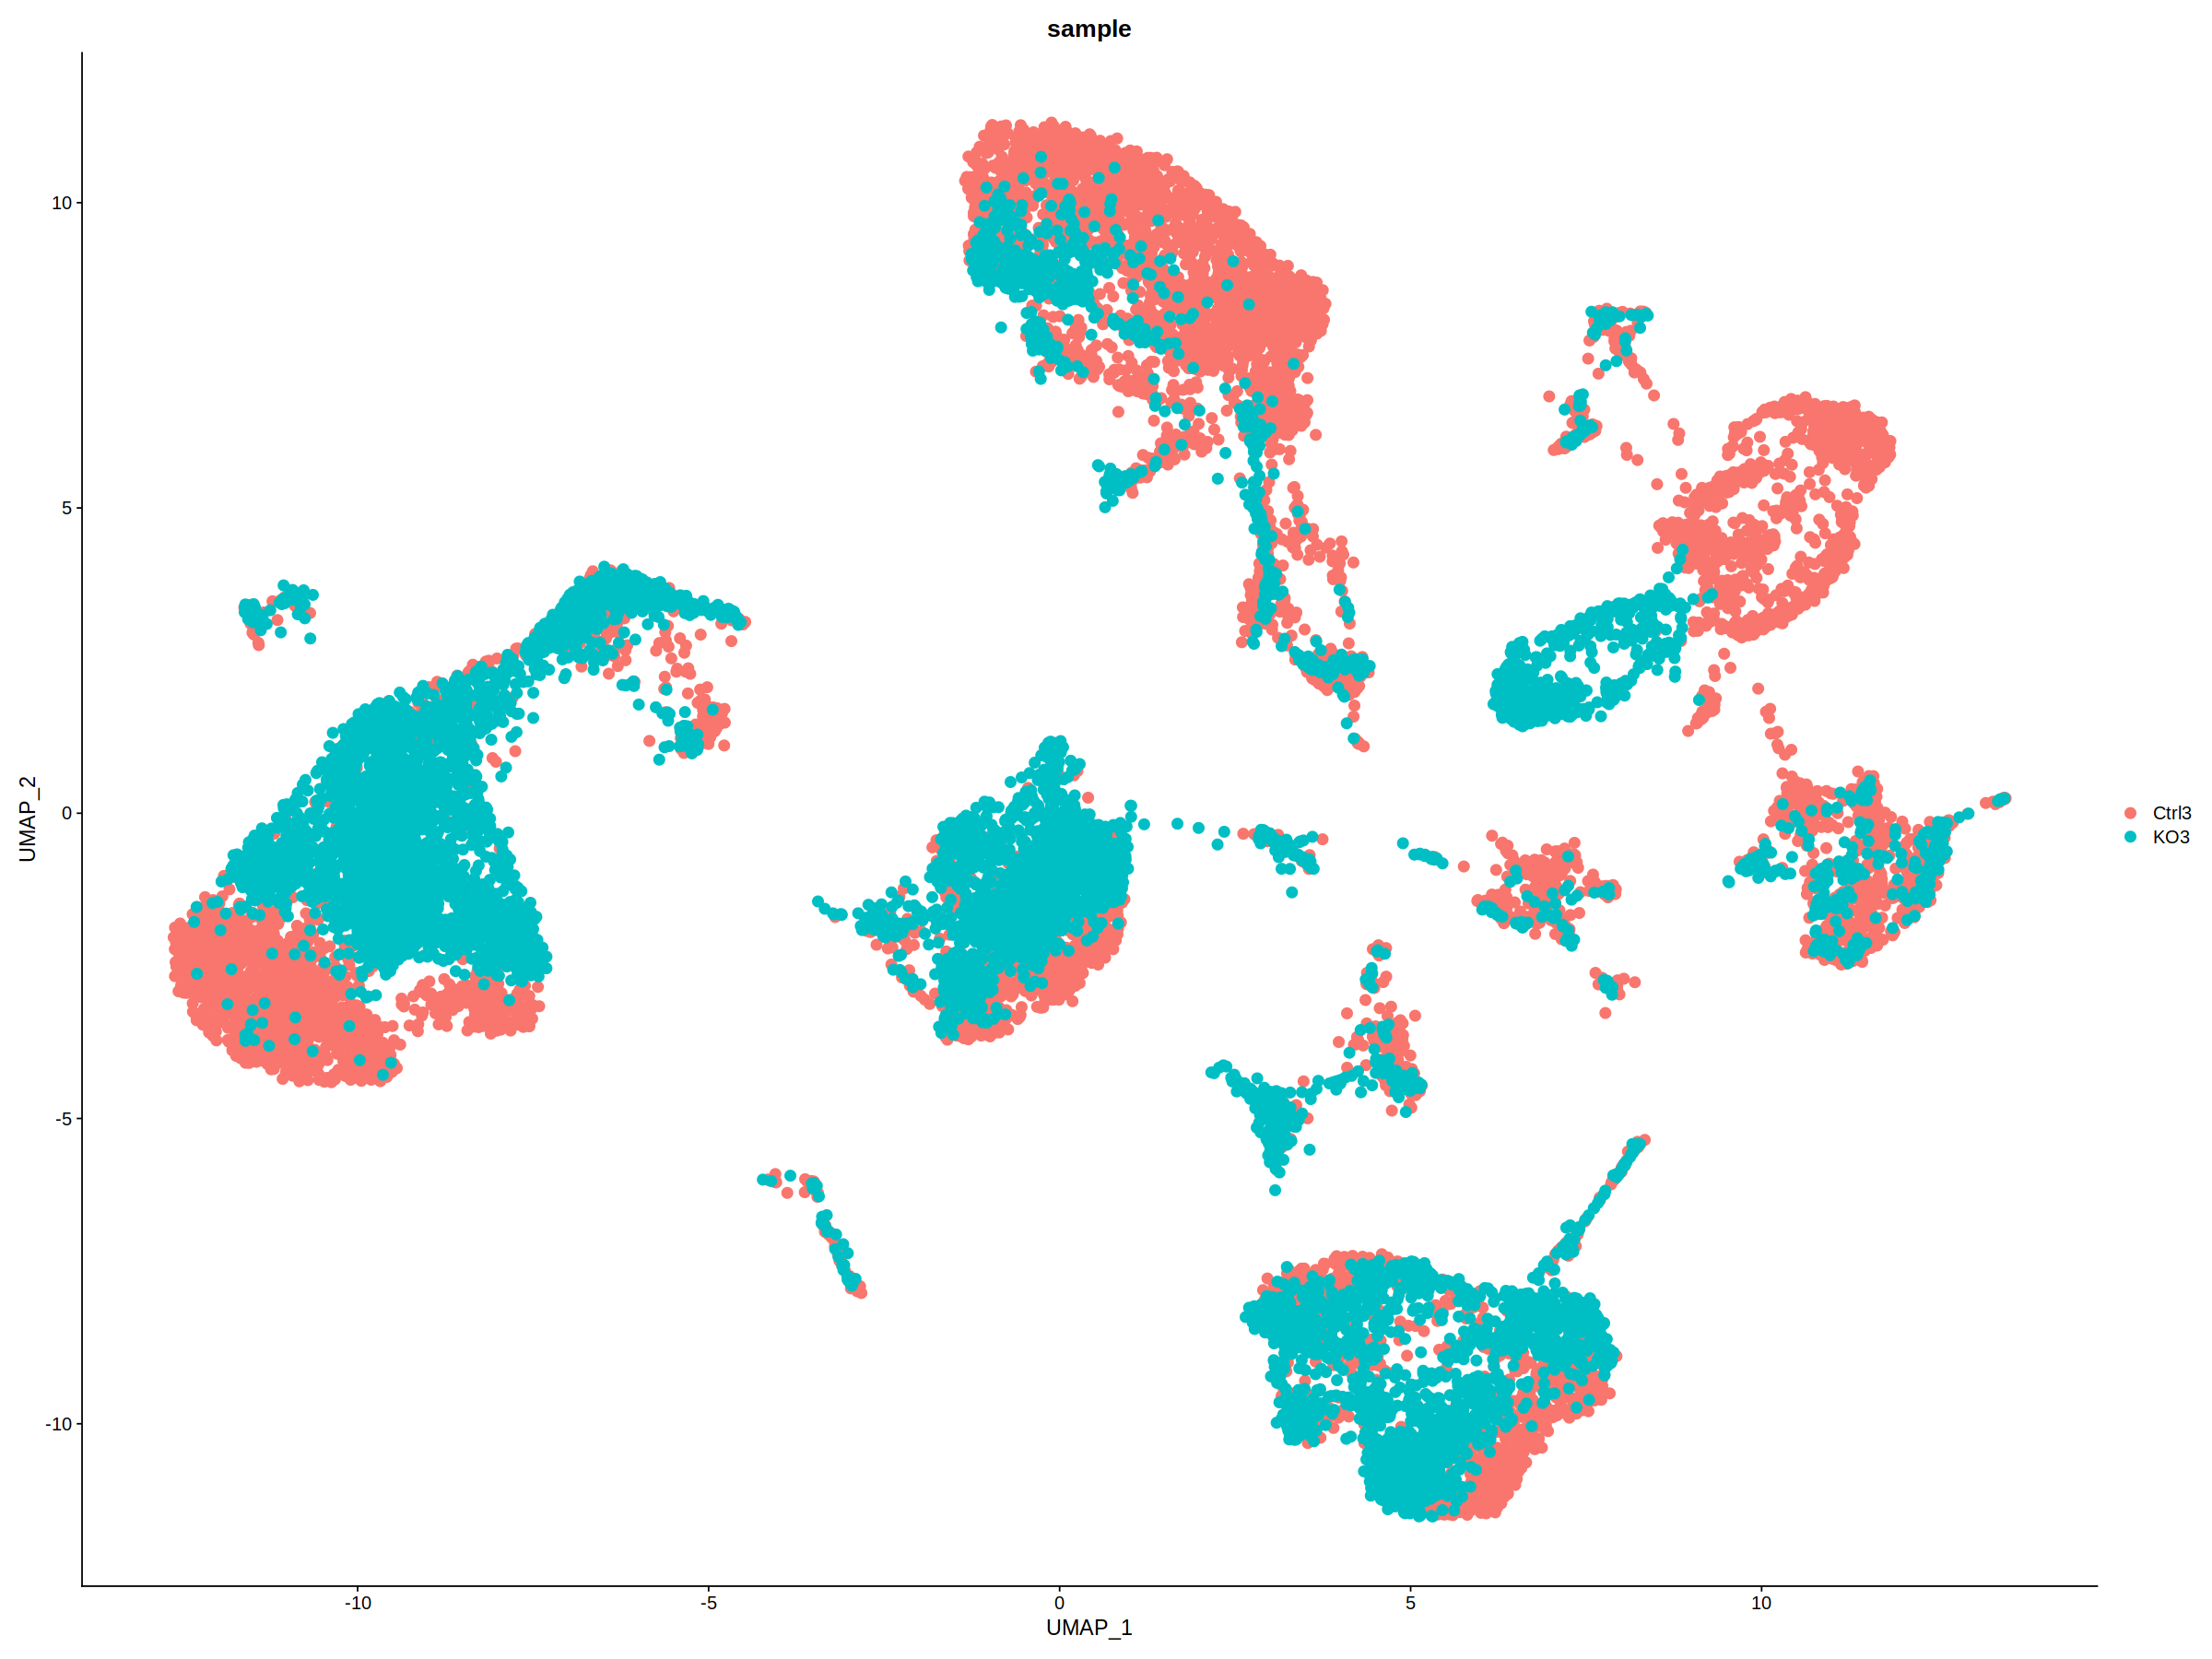

In [111]:
p8= DimPlot(combined2, reduction = "umap", group.by = 'sample',  repel = TRUE,pt.size = 3)
p8

In [112]:

p9= FeaturePlot(combined2, 
  features = c("nCount_RNA","nFeature_RNA","percent.meto"
               ,"percent.ribo","percent.hemo","percent.plat","log_nCount_RNA","log_nFeature_RNA"), 
                pt.size = 3,reduction = "umap", ncol = 3, 
                  cols = c("lightgrey", "darkred"))

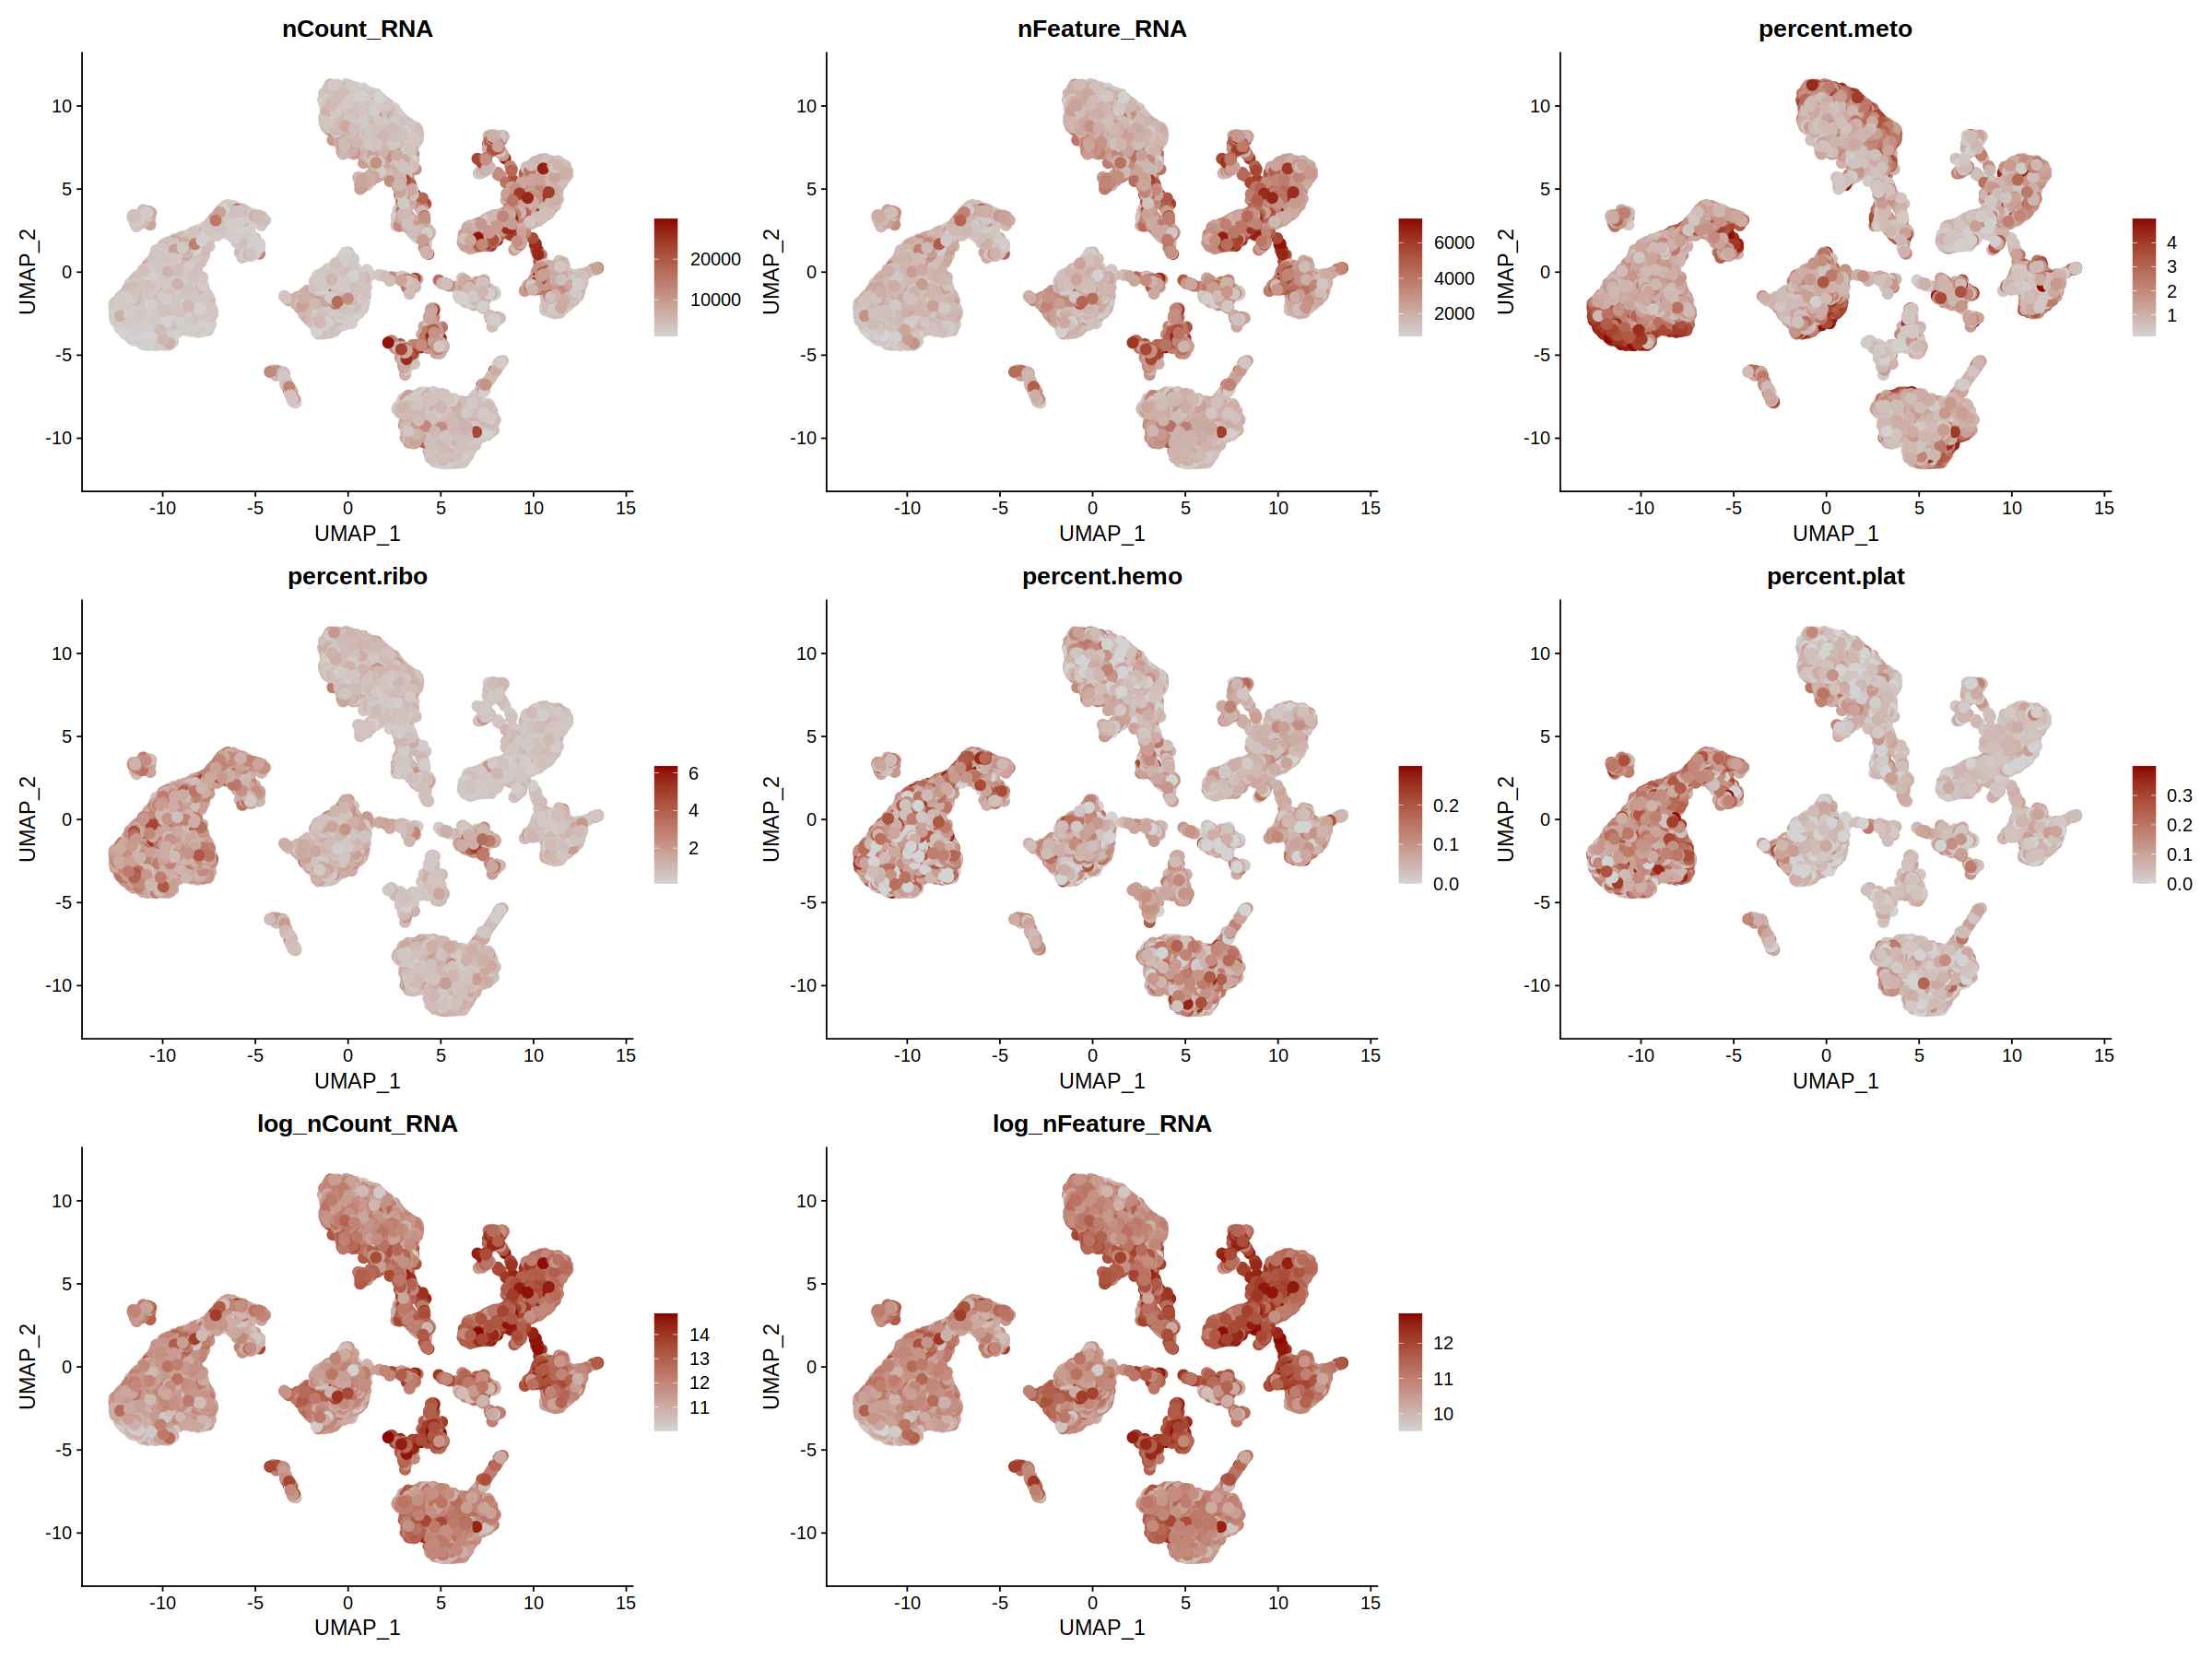

In [113]:
p9

# Load and cluster refrence dataset

In [114]:
ref = read.csv('/home/lemsaraa/amina/prj_wt1os/ref/dge.txt',sep = '\t')
rownames(ref)=toupper(rownames(ref))

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 19397 by 12954

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |======================================================================| 100%


Found 5 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 19397 genes



  |======================================================================| 100%


Computing corrected count matrix for 19397 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 2.808497 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

PC_ 1 
Positive:  NPHS2, CDKN1C, NUPR1, CLIC3, GADD45A, CD59A, CTSL, MYL12A, ARHGAP24, VEGFA 
	   ENPEP, EGR1, DPP4, GOLIM4, PODXL, VIM, COL4A3, RASL11A, NPHS1, SEPT11 
	   NAP1L1, NES, SEMA3G, NPNT, TMOD3, CALM2, RAB3B, KLF6, CRYAB, TCF21 
Negative:  SRGN, LY6C1, EMCN, CDKN1A, IFITM3, EGFL7, IGFBP5, CD24A, EDNRB, APOLD1 
	   CTLA2A, EMP1, LY6E, S100A6, FLT1, ADGRF5, CRIP1, CLIC4, EHD3, SLFN5 
	   PI16, GIMAP6, PECAM1, KDR, 1810011O10RIK, GIMAP4, FXYD5, RAMP2, PBX1, CYP4B1 
PC_ 2 
Positive:  CDKN1C, NPHS2, NUPR1, TM4SF1, SPARC, PLAT, VIM, CLIC5, PODXL, TIMP3 
	   FOSB, EGR1, ANXA1, CLIC3, NES, ANXA2, H2-D1, NFKBIA, MYL12A, TMOD3 
	   GADD45A, CD59A, CTSL, ATF3, SEPT11, SEMA3G, VEGFA, IFRD1, GOLIM4, EMCN 
Negative:  DEFB1, ATP1B1, FXYD2, MT1, SPP1, LDHB, PVALB, SLC12A3, NUDT4, TMEM213 

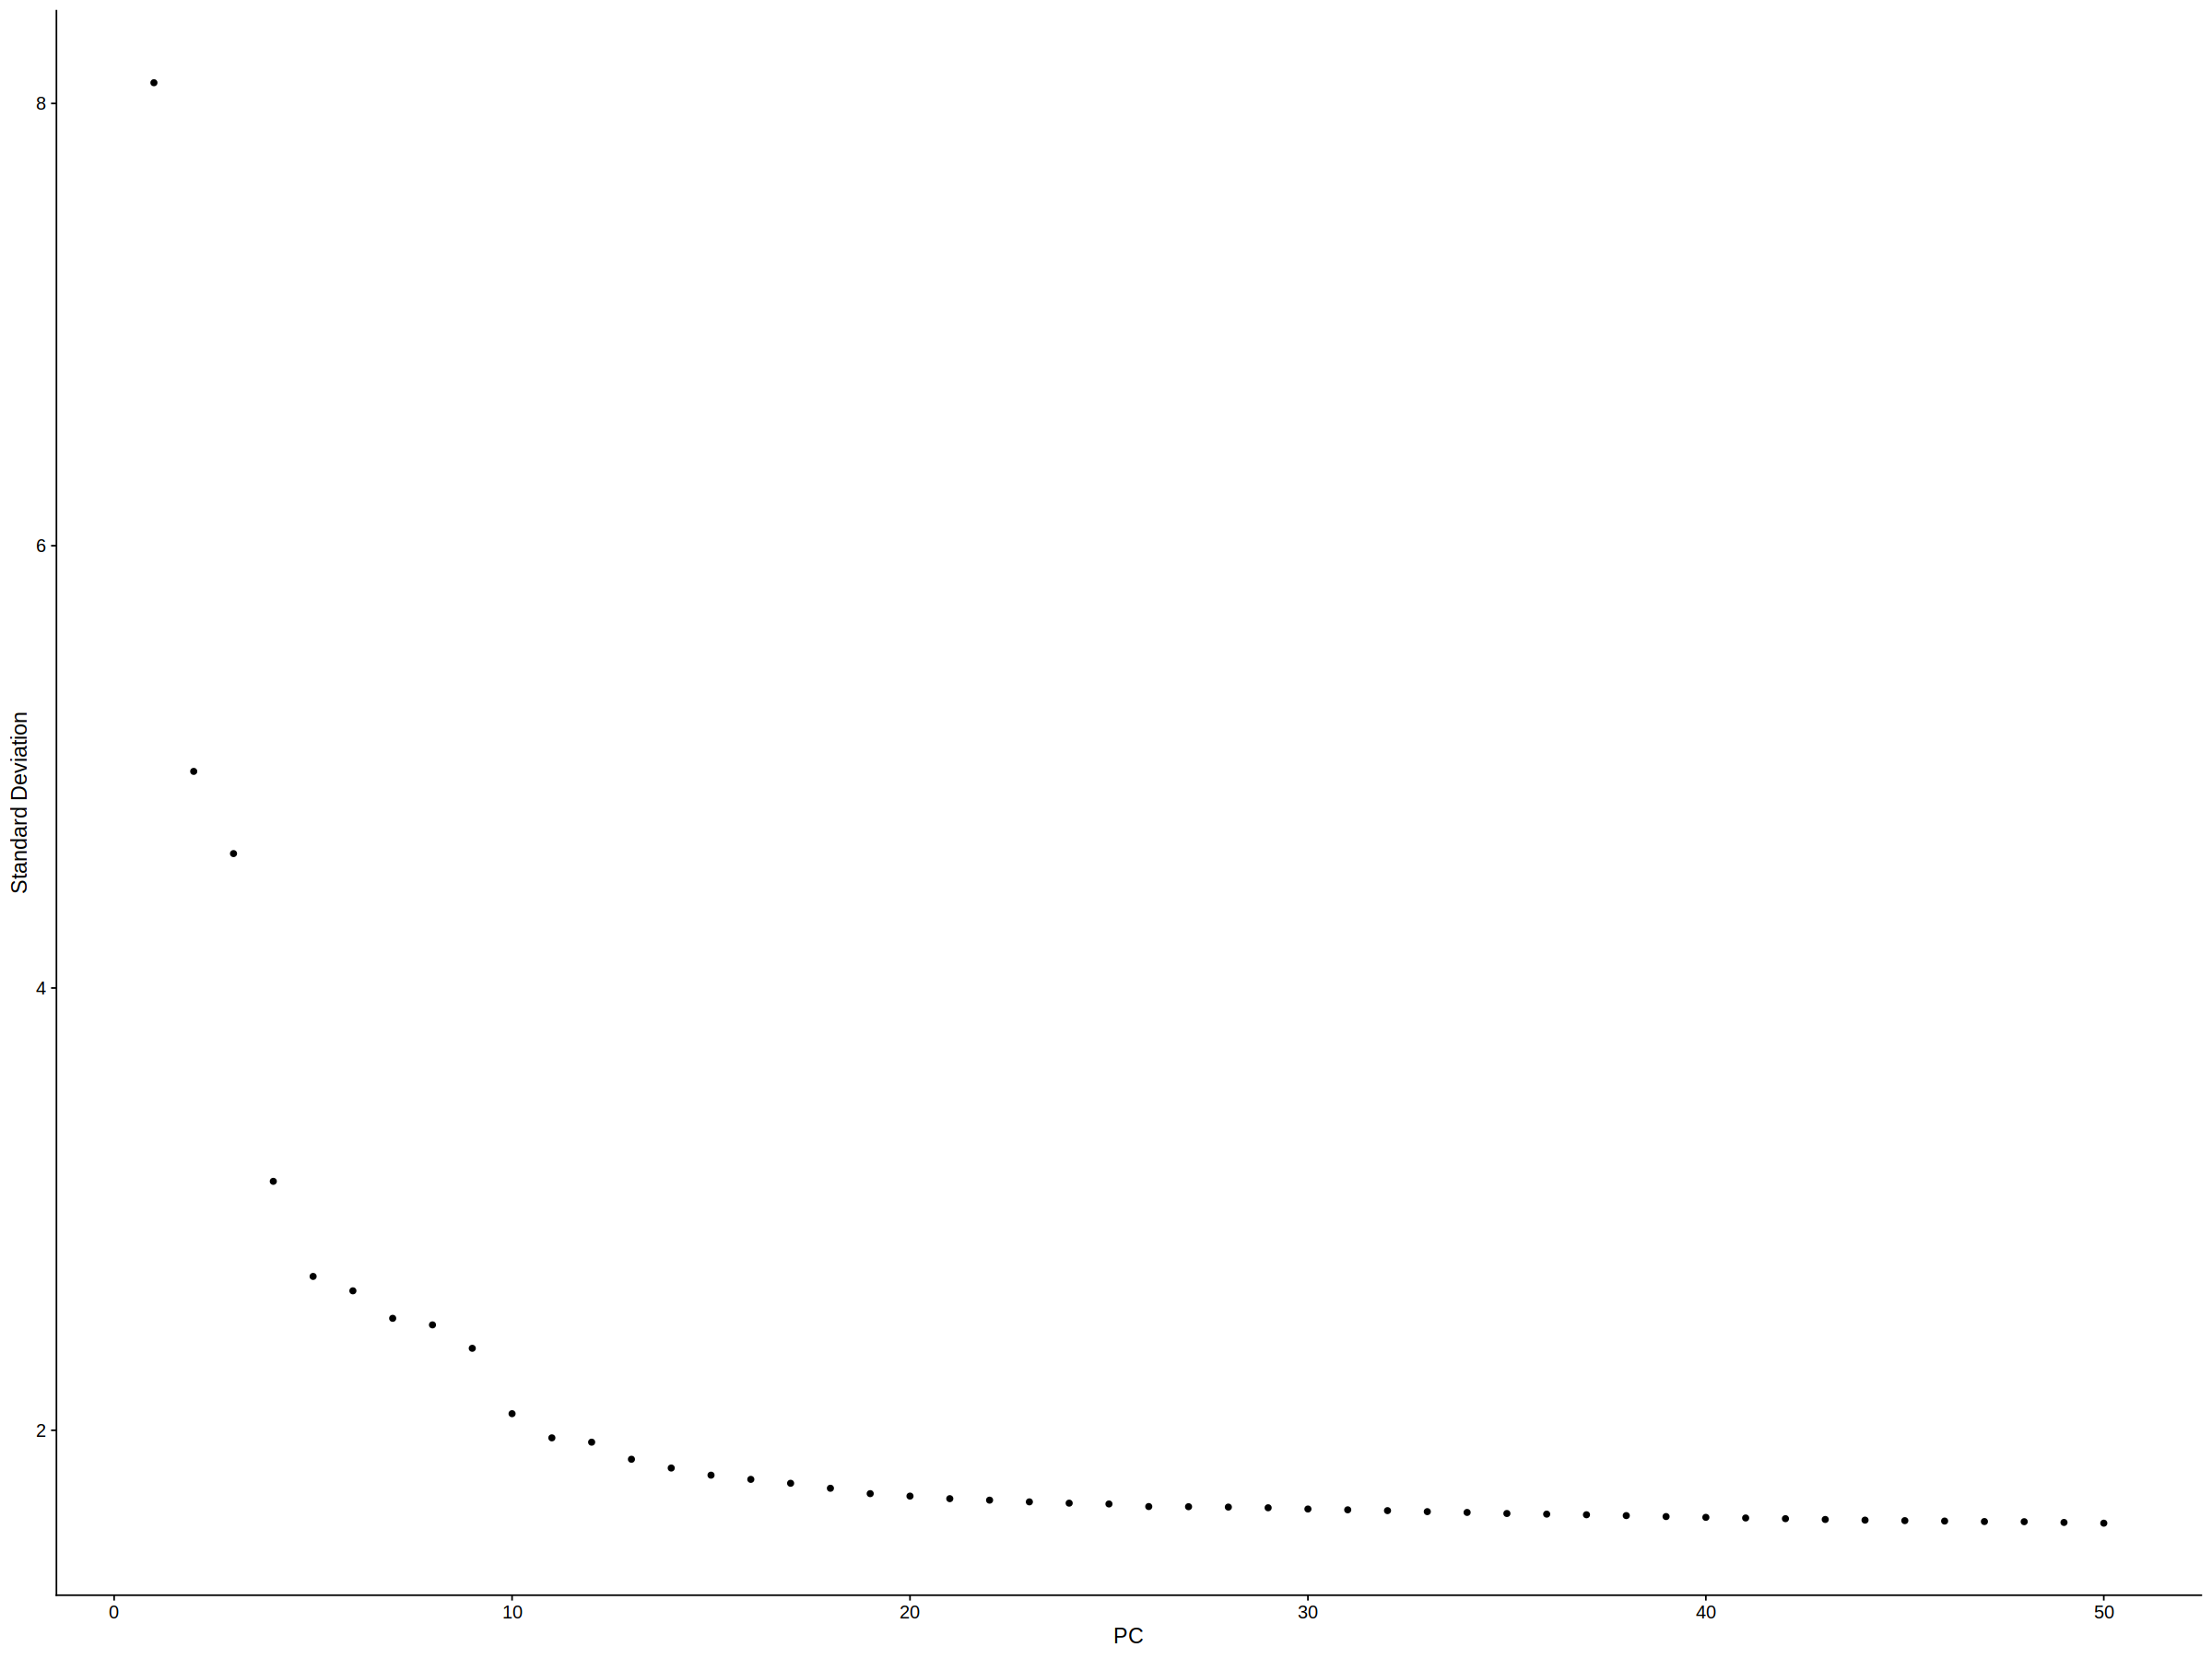

In [115]:
reference<-CreateSeuratObject(counts= ref)
reference@meta.data$celltype= sapply(strsplit(as.character(rownames(reference@meta.data)), "_"), tail, 1)
reference<-SCTransform(reference)
reference <- RunPCA(reference)
ElbowPlot(reference, ndims = 50)
reference <- RunUMAP(reference, dims = 1:50,umap.method = "uwot",return.model = TRUE)

In [116]:
anchors <- FindTransferAnchors(
  reference = reference,
  query = combined2,
  normalization.method = "SCT",
  reference.reduction = "pca",
  dims = 1:50
)
combined2 <- MapQuery(
  anchorset = anchors,
  query = combined2,
  reference = reference,
  refdata ="celltype",
  reference.reduction = "pca", 
  reduction.model = "umap"
)

Normalizing query using reference SCT model

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 1193 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels


Integrating dataset 2 with reference dataset

Finding integration vectors

Integrating data

Computing nearest neighbors

Running UMAP projection

11:01:33 Read 19085 rows

11:01:33 Processing block 1 of 1

11:01:33 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

11:01:33 Initializing by weighted average of neighbor coordinates using 1 thread

11:01:34 Commencing optimization for 67 epochs, with 572550 positive edges

11:01:36 Finished



In [117]:
p10= DimPlot(combined2, reduction = "ref.pca", group.by = "sample",  repel = TRUE,pt.size = 3) +theme_s
p11= DimPlot(combined2, reduction = "pca", group.by = "sample",  repel = TRUE,pt.size = 3)  +theme_s

In [118]:
combined2$predicted.id_refined = ifelse(combined2$predicted.id.score > 0.8 
                                        | combined2$predicted.id == combined2$celltype_level1,
                                           combined2$predicted.id ,'mixed')
combined2$predicted.id_refined = ifelse(combined2$predicted.id_refined== 'Mesangium' & combined2$celltype_level1 != 'Mesangium' 
                                        ,'mixed',combined2$predicted.id_refined)
combined2$predicted.id_refined = ifelse(combined2$predicted.id_refined== 'mixed' & combined2$celltype_level1 == 'Tubules' 
                                        ,'Tubules',combined2$predicted.id_refined)

# combined2$predicted.id_refined = ifelse(combined2$predicted.id.score > 0.8,
#                                            combined2$predicted.id , 'mixed')
Idents(combined2) = combined2$predicted.id_refined
p13 = VlnPlot(combined2, features = c('PECAM1','FLT1','EMCN','MYL9','REN1','ACTA2','MAFB','NPHS2','NPHS1'
                                ,'ATP1B1','SLC12A3','FXYD2','LYZ2','H2-AA','CD74'
                                ))


In [119]:
p12 = DotPlot(combined2, features = c('PECAM1','FLT1','EMCN','MYL9','REN1','ACTA2','MAFB','NPHS2','NPHS1'
                                ,'ATP1B1','SLC12A3','FXYD2','LYZ2','H2-AA','CD74')) + RotatedAxis()


In [120]:

p14 = FeaturePlot(combined2, features = c("NPHS1","NPHS2", "LYZ2","EMCN",'MYL9',"SLC12A3") 
                  ,pt.size = 3,  reduction = "umap", cols = c("lightgrey", "darkred")
                  , ncol = 2) & theme(plot.title = element_text(size = 10))+theme_s


In [121]:
p15 = VlnPlot(
  object = combined2,
  features = c("predicted.id.score"),
  group.by = 'predicted.id_refined',
  split.by = 'sample',
  pt.size = 3
)+theme_s




In [122]:
table(combined2$predicted.id_refined)


Endothelium      Immune   Mesangium       mixed   Podocytes     Tubules 
       6270         296         118        2454        3146        6801 

In [123]:
count_cells = combined2@meta.data %>% count(sample, predicted.id_refined, sort = TRUE)

In [124]:
p16 =ggplot(count_cells, aes(x = predicted.id_refined, y = n, fill = sample)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "# cells per cellType and sample", x = "CellType", y = "Value") +theme_s

In [125]:
p17 = DimPlot(combined2, reduction = "ref.umap", group.by = "predicted.id_refined", 
              repel = TRUE,pt.size = 3) +theme_s


In [138]:
p0_ = VlnPlot(combined2, assay = 'SCT', split.by = 'sample',features = c('WT1OS'))
Idents(combined2)= combined2$sample
p0 = VlnPlot(combined2, assay = 'SCT', features = c('WT1OS'))

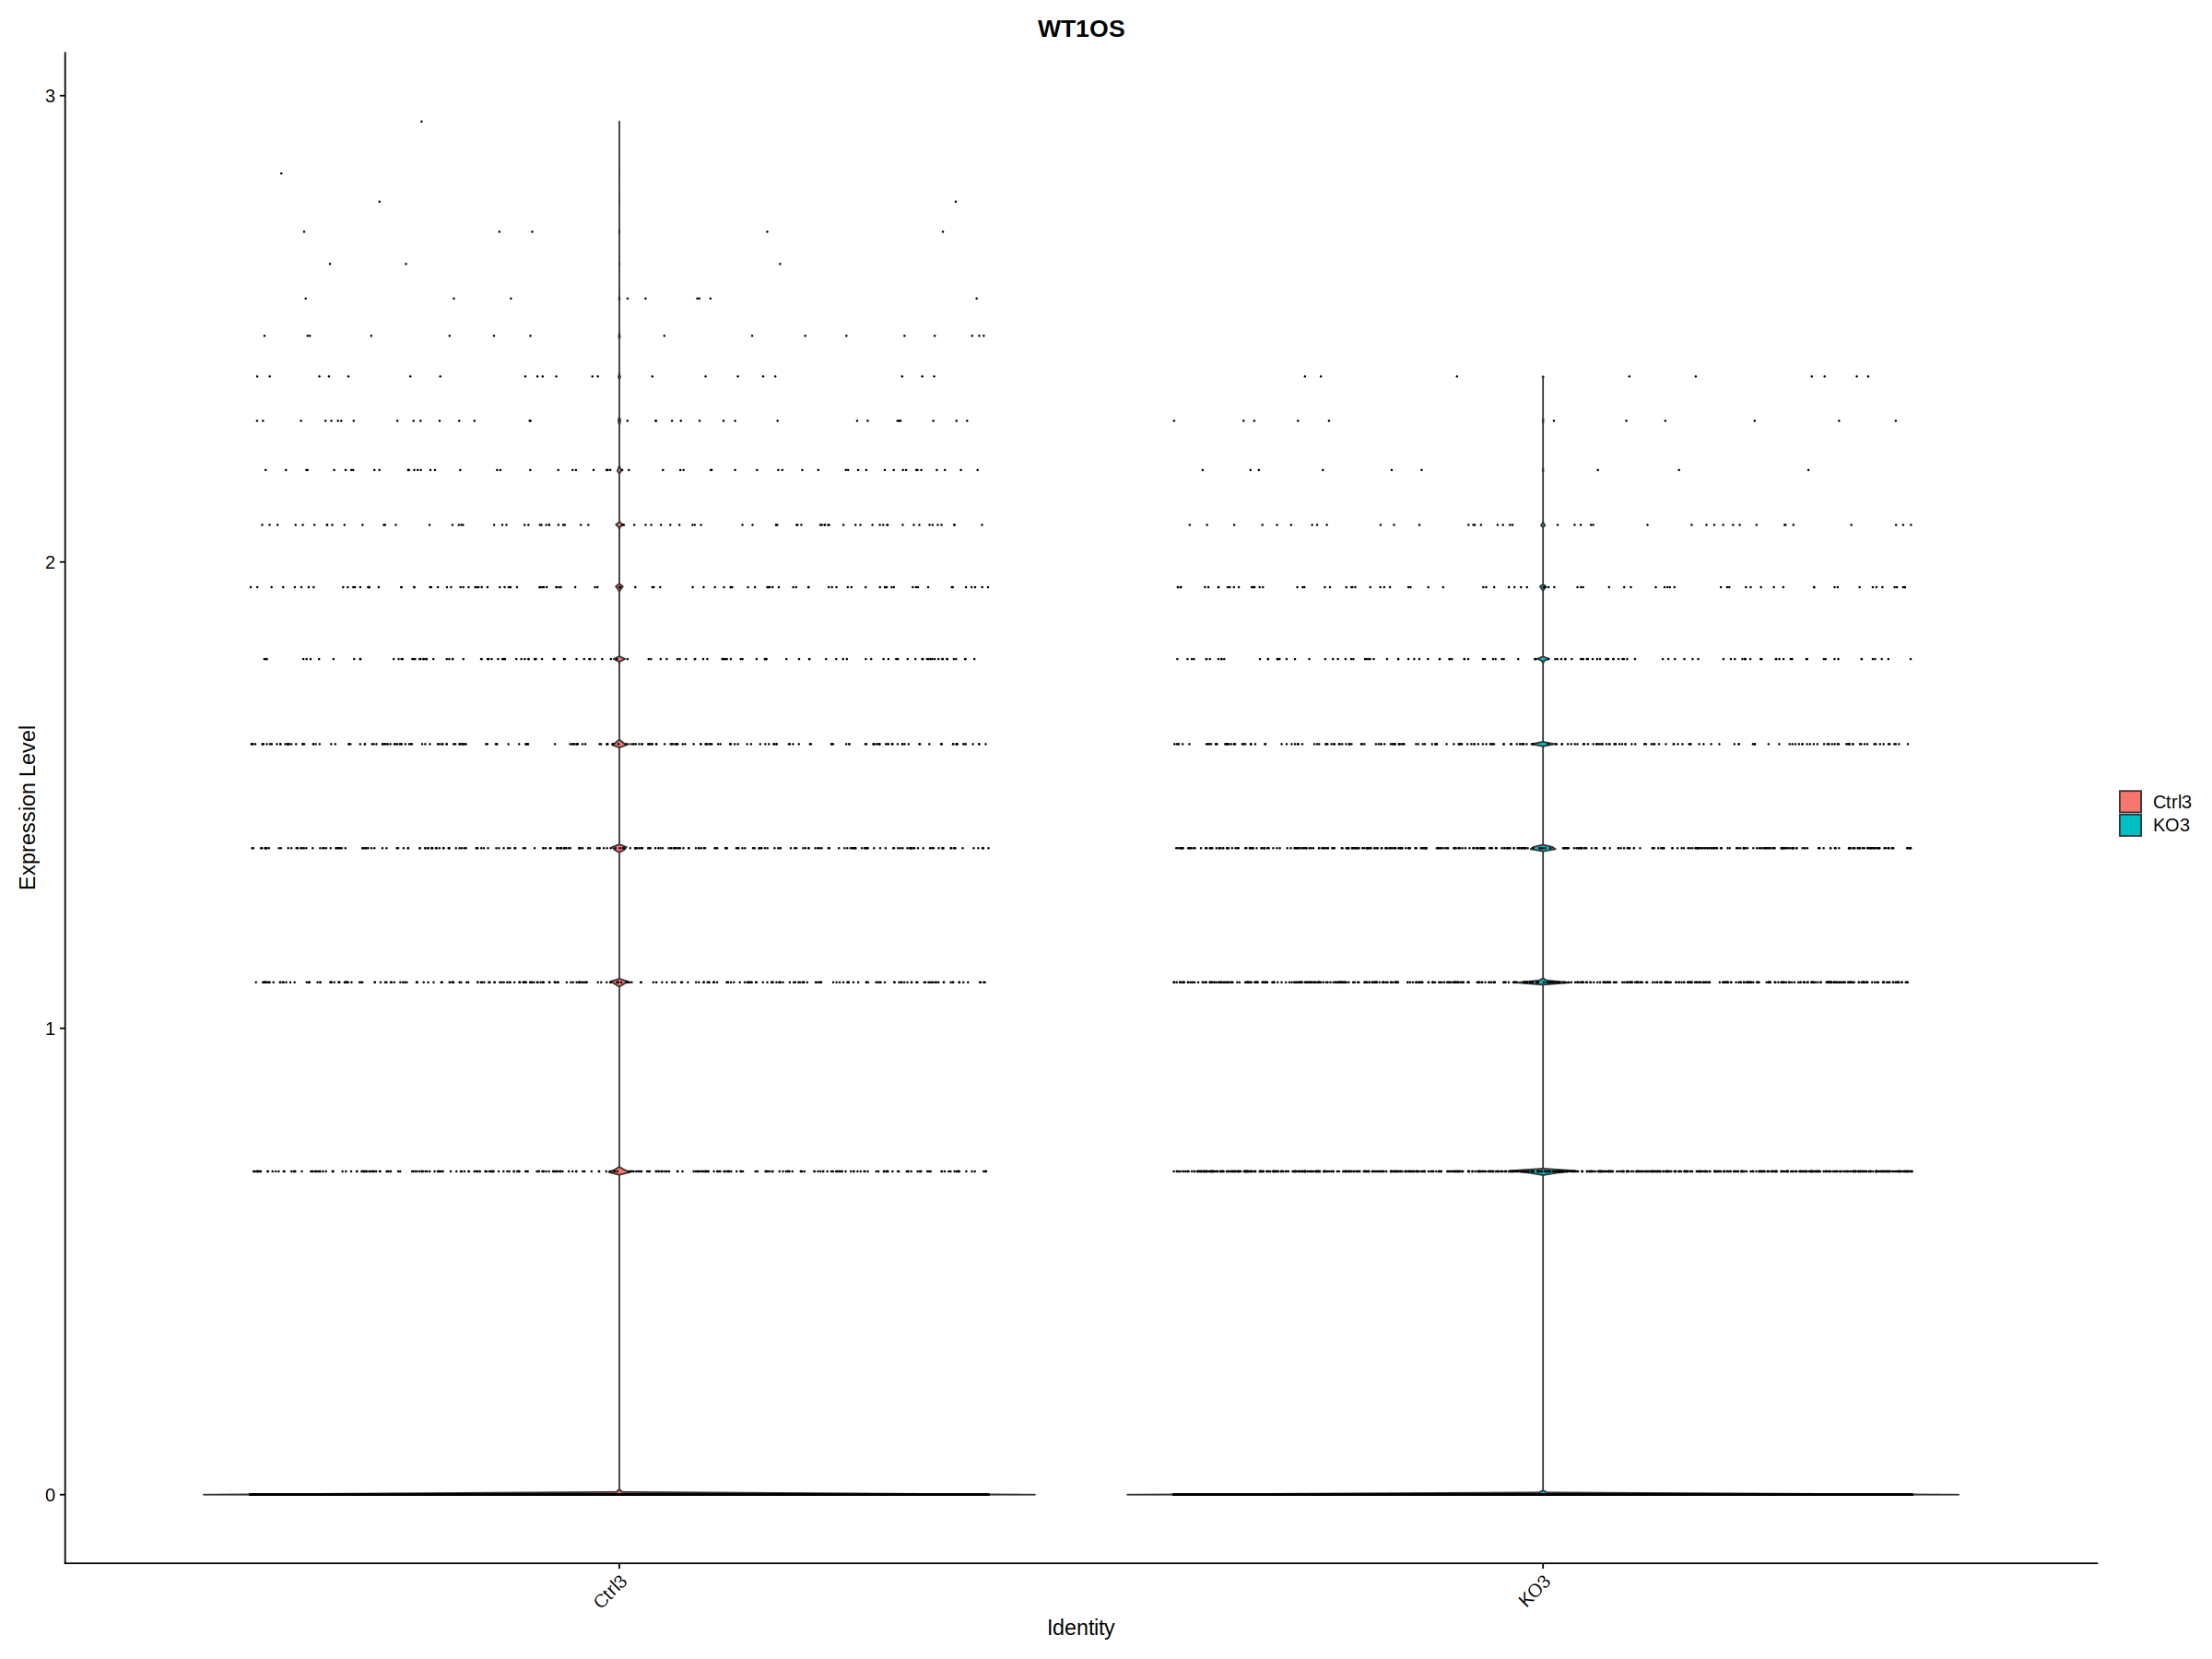

In [139]:
p0

In [128]:
Idents(combined2) = combined2$sample
# combined2$celltype.sample2<- paste(Idents(combined2), combined2$sample2, sep = "_")
# combined2$celltype <- Idents(combined2)
# Idents(combined2) <- combined2$celltype.sample2
markers_de <-  FindMarkers(combined2, ident.1 = "KO3", ident.2 = "Ctrl3", verbose = FALSE
                          ,logfc.threshold = 0.1,min.pct = 0)
markers_de_all = rownames(markers_de %>% 
    filter(abs(avg_log2FC)>1))


In [129]:
# Idents(combined2) = combined2$sample2
combined2$celltype.sample2<- paste(combined2$predicted.id_refined, combined2$sample, sep = "_")
# combined2$celltype <- Idents(combined2)
Idents(combined2) <- combined2$celltype.sample2
markers_de1 <- FindMarkers(combined2, ident.1 = "Podocytes_KO3", ident.2 = "Podocytes_Ctrl3", verbose = FALSE
                          ,logfc.threshold = 0.1,min.pct = 0)
markers_de_all_podocytes = rownames(markers_de1 %>%
    filter(abs(avg_log2FC)>1))


In [130]:
p19=venn(list(Ctrl_KO_Podocytes=markers_de_all_podocytes,Ctrl_KO=markers_de_all),zcolor="style",ilcs=1,ggplot=TRUE)


In [132]:
logFC <- markers_de1$avg_log2FC
pval <- markers_de1$p_val_adj

results <- data.frame(logFC=logFC, pval=pval, protein=rownames(markers_de1))

# Sort by log fold change
results <- results[order(abs(results$logFC), decreasing=TRUE),]

# Set cutoff for log fold change and p-value
logFC_cutoff <- 1
pval_cutoff <- 0.05

# Get top proteins based on log fold change and p-value
top_proteins <- results[results$protein == 'WT1OS' | (abs(results$logFC) > logFC_cutoff & results$pval < pval_cutoff),]

# Create volcano plot
p21=ggplot(results, aes(x=logFC, y=-log10(pval))) + 
  geom_point(color="black", alpha=0.6, size=1) +
  theme_s +
  ggtitle('CTRL_KO_Podocytes') +   
  scale_x_continuous("Log Fold Change") +
  scale_y_continuous("-Log10(p-value)") +
  geom_hline(yintercept=-log10(pval_cutoff), linetype="dashed", color="red") +
  geom_vline(xintercept=c(-logFC_cutoff,logFC_cutoff), linetype="dashed", color="blue") +
  geom_text_repel(data=top_proteins, aes(x=logFC, y=-log10(pval), label=protein), size=6)+
  geom_point(color = ifelse(results$protein %in% top_proteins$protein, "red", "grey50"))
    
    


In [133]:
logFC <- markers_de$avg_log2FC
pval <- markers_de$p_val_adj

results <- data.frame(logFC=logFC, pval=pval, protein=rownames(markers_de))

# Sort by log fold change
results <- results[order(abs(results$logFC), decreasing=TRUE),]

# Set cutoff for log fold change and p-value
logFC_cutoff <- 1
pval_cutoff <- 0.05

# Get top proteins based on log fold change and p-value
top_proteins <- results[results$protein == 'WT1OS' | (abs(results$logFC) > logFC_cutoff & results$pval < pval_cutoff),]
# Create volcano plot
p20=ggplot(results, aes(x=logFC, y=-log10(pval))) + 
  geom_point(color="black", alpha=0.6, size=1) +
  theme_s +
  ggtitle('CTRL_KO') +   
  scale_x_continuous("Log Fold Change") +
  scale_y_continuous("-Log10(p-value)") +
  geom_hline(yintercept=-log10(pval_cutoff), linetype="dashed", color="red") +
  geom_vline(xintercept=c(-logFC_cutoff,logFC_cutoff), linetype="dashed", color="blue") +
  geom_text_repel(data=top_proteins, aes(x=logFC, y=-log10(pval), label=protein), size=6) +
  geom_point(color = ifelse(results$protein %in% top_proteins$protein, "red", "grey50"))
    


In [135]:
pdf(file ="results_batch2.pdf",   # The directory you want to save the file in
    width = 15, # The width of the plot in inches
    height = 12)

p1
p2
par(mar = c(8,5,2,2))
boxplot(t(as.matrix(C[rownames(C)[most_expressed], ])), las = 1, xlab = "% total count per cell",
    col = (scales::hue_pal())(20)[20:1], horizontal = TRUE, main ='Top 20 expressed genes')
p3
p4
p5
p11
p8
p9
p6
p7
p10
p17
p12
p13
p14
#p15
p16
p0
p0_
p19
p20
p21
dev.off()

Warning message:
“ggrepel: 12 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


png 
  2

In [87]:
saveRDS(combined2, 'combined2_batch2.rds')
# saveRDS(markers, 'markers.rds')

ERROR: Error in saveRDS(combined2, "combined2_batch2.rds"): error writing to connection


In [2]:
combined2 = readRDS( 'combined2.rds')

In [12]:
dim(combined2)

[1] 20407  9830

In [70]:
Idents(combined2) = combined2$predicted.id_refined
combined2$celltype.sample2<- paste(Idents(combined2), combined2$sample2, sep = "_")
combined2$celltype <- Idents(combined2)
Idents(combined2) <- combined2$celltype.sample2
b.interferon.response <- FindMarkers(combined2, ident.1 = "Podocytes_KO", ident.2 = "Podocytes_CTRL", verbose = FALSE)
b.interferon.response %>%
    filter(abs(avg_log2FC)>1)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
UTY,3.168363e-246,1.036806,0.492,0.001,6.465679e-242
XIST,1.635969e-208,-1.392943,0.341,0.981,3.338523e-204
PDE10A,2.912906e-118,-1.211779,0.442,0.786,5.944367e-114
KAP,1.816141e-117,1.402784,0.730,0.360,3.706198e-113


In [294]:
Idents(combined2) = combined2$predicted.id_refined
combined2$celltype.sample2<- paste(Idents(combined2), combined2$sample, sep = "_")
combined2$celltype <- Idents(combined2)
Idents(combined2) <- combined2$celltype.sample2
ko1_ctr1 <- FindMarkers(combined2, ident.1 = "Podocytes_KO1", ident.2 = "Podocytes_Ctrl1", verbose = FALSE)
ko1_ctr1= ko1_ctr1 %>% filter(abs(avg_log2FC)>1)
ko1_ctr1_genes = rownames(ko1_ctr1)

In [295]:
ko2_ctr1 <- FindMarkers(combined2, ident.1 = "Podocytes_KO2", ident.2 = "Podocytes_Ctrl1", verbose = FALSE)
ko2_ctr1= ko2_ctr1 %>% filter(abs(avg_log2FC)>1)
ko2_ctr1_genes = rownames(ko2_ctr1)

In [296]:
ko1_ctr2 <- FindMarkers(combined2, ident.1 = "Podocytes_KO1", ident.2 = "Podocytes_Ctrl2", verbose = FALSE)
ko1_ctr2= ko1_ctr2 %>% filter(abs(avg_log2FC)>1)
ko1_ctr2_genes = rownames(ko1_ctr2)

In [297]:
ko2_ctr2 <- FindMarkers(combined2, ident.1 = "Podocytes_KO2", ident.2 = "Podocytes_Ctrl2", verbose = FALSE)
ko2_ctr2= ko2_ctr2 %>% filter(abs(avg_log2FC)>1)
ko2_ctr2_genes = rownames(ko2_ctr2)

In [299]:
ko1_ctr2_genes

[1] "XIST"   "UTY"    "ZBTB16" "FKBP5"  "KAP"    "PDE10A"

In [300]:
ko2_ctr1_genes

[1] "SLC12A1"

In [301]:
ko1_ctr1_genes

[1] "XIST"   "UTY"    "KAP"    "ZBTB16" "FKBP5"  "PDE10A"

In [285]:
Idents(combined2) = combined2$predicted.id_refined
combined2$celltype.sample2<- paste(Idents(combined2), combined2$sample, sep = "_")
combined2$celltype <- Idents(combined2)
Idents(combined2) <- combined2$celltype.sample2
b.interferon.response <- FindAllMarkers(combined2, verbose = FALSE)
b.interferon.response %>%
    group_by(cluster) %>%
    slice_max(n = 10, order_by = abs(avg_log2FC))

In [ ]:
Idents(combined2) = combined2$predicted.id_refined
combined2$celltype.sample2<- paste(Idents(combined2), combined2$sample2, sep = "_")
combined2$celltype <- Idents(combined2)
Idents(combined2) <- combined2$celltype.sample2
b.interferon.response <- FindMarkers(combined2, ident.1 = "Podocytes_KO", ident.2 = "Podocytes_CTRL", verbose = FALSE)
b.interferon.response %>%
    slice_max(n = 10, order_by = abs(avg_log2FC))

In [269]:
avg.t.cells <- log1p(AverageExpression(t.cells, verbose = FALSE)$RNA)
avg.t.cells$gene <- rownames(avg.t.cells)

Warning message in PseudobulkExpression(object = object, pb.method = "average", :
“Exponentiation yielded infinite values. `data` may not be log-normed.”
Warning message in avg.t.cells$gene <- rownames(avg.t.cells):
“Coercing LHS to a list”


In [ ]:
# cell type prediction scores
DefaultAssay(combined2) <- 'prediction.score.id'
p4 <- FeaturePlot(combined2, features = c( 'Endothelium','Podocytes','Mesangium','Tubules','Immune'),pt.size = 3,  reduction = "ref.umap", ncol = 3, 
                  cols = c("lightgrey", "darkred"))
p4

In [ ]:
# cell type prediction scores
DefaultAssay(combined2) <- 'prediction.score.id'
p4 <- FeaturePlot(combined2, features = c( 'Endothelium','Podocytes','Mesangium','Tubules','Immune'),  pt.size = 3,reduction = "umap", ncol = 3, 
                  cols = c("lightgrey", "darkred"))
p4

In [ ]:
#merge reference and query
reference$id <- 'reference'
reference$batch <- 'ref'
reference$predicted.id.score <- 1
combined2$id <- 'query'
reference$cells <- reference$celltype
combined2$cells <- combined2$predicted.id
refquery <- merge(reference, combined2)
refquery[["pca"]] <- merge(reference[["pca"]], combined2[["ref.pca"]])
refquery <- RunUMAP(refquery, reduction = 'pca', dims = 1:30)
p1 = DimPlot(refquery, group.by = 'id', shuffle = TRUE,pt.size = 3 )
p2 = DimPlot(refquery, group.by = 'cells', shuffle = TRUE,pt.size = 3)
p3 = DimPlot(refquery, group.by = 'batch', shuffle = TRUE,pt.size = 3)



# AUCell

In [ ]:
MarkerGenesets <- readRDS("~/amina/prj_wt1os/ref/MarkerGenesets.rds")
counts <- GetAssayData(object = combined2,assay = 'RNA', slot = "counts")


In [ ]:
podo = unique(c(MarkerGenesets$susztak[['podocyte']]@geneIds
                ,MarkerGenesets$clark[['Podocyte']]@geneIds                
#               ,MarkerGenesets$scDB[['Podocyte']]@geneIds
               ))

endo = unique(c(MarkerGenesets$susztak[['endothelial']]@geneIds
              ,MarkerGenesets$clark[['Endothelial Cell']]@geneIds
#                 ,MarkerGenesets$scDB[['Endothelial cell']]@geneIds
               ))

mesan = unique(c(MarkerGenesets$clark[['Mesangial Cells']]@geneIds
#                  ,MarkerGenesets$scDB[['Mesangial cell']]@geneIds
                ))

tub = unique(c(MarkerGenesets$susztak[['proximal tubule']]@geneIds
              ,MarkerGenesets$clark[['Connecting Tubule']]@geneIds
#                ,MarkerGenesets$scDB[['Proximal tubule cell']]@geneIds
#               ,MarkerGenesets$scDB[['Distal convoluted tubule cell']]@geneIds
              )
            )
immune = c('TYROBP','FCER19','LYZ2','BMP2','MAPHB2','CD74','H2-AA')
all_cell = list(Podocytes= podo, Endothelium=endo, Mesangium=mesan, Tubules=tub, Immune=immune)
i=1            
for (cell in names(all_cell) ){
i=i*4
counts <- GetAssayData(object = combined2,assay = 'RNA', slot = "counts")
cell_rankings <- AUCell_buildRankings(counts)
cells_AUC <- AUCell_calcAUC(toupper(all_cell[cell][[1]]), cell_rankings)
cells_assignment <- AUCell_exploreThresholds(cells_AUC, plotHist = TRUE, assign=TRUE)
cor( getAUC(cells_AUC)["geneSet",], combined2@assays$prediction.score.id@data[cell,])
combined2@meta.data[cell] <- ifelse(colnames(combined2) %in% cells_assignment$geneSet$assignment, i, 0) 
}

In [ ]:

combined2@meta.data['ann_aucell'] = rowSums(combined2@meta.data[,c('Podocytes','Endothelium','Mesangium','Tubules','Immune')])
combined2@meta.data['ann_aucell']<- ifelse(combined2@meta.data['ann_aucell'][[1]] 
                                     %in% c(0,4,16,64,256,1024),combined2@meta.data['ann_aucell'][[1]] , 'mixte')
combined2@meta.data['ann_aucell'] <- as.character(factor(combined2@meta.data['ann_aucell'][[1]], c('0','4','16','64','256','1024','mixte'),
       c('notDetected','Podocytes','Endothelium','Mesangium','Tubules','Immune','mixte')))
combined2@meta.data['ann_aucell_ref']<- ifelse(combined2@meta.data['predicted.id.score'][[1]] 
                                     >0.8,combined2@meta.data['predicted.id'][[1]] 
                                               , combined2@meta.data['ann_aucell'][[1]])



In [ ]:
p1 = DimPlot(combined2, reduction = "ref.umap", group.by = "batch"
             ,   repel = TRUE,pt.size = 3) +
  theme(legend.text = element_text(size=16))+
theme(plot.margin = margin(0.5,0.5,0.5,0.5, "cm"),axis.text=element_blank(),axis.ticks=element_blank())


p2 = DimPlot(combined2, reduction = "ref.umap",cols= R_colors, group.by = "predicted.id"
             ,   repel = TRUE,pt.size = 3) +
  theme(legend.text = element_text(size=16))+
theme(plot.margin = margin(0.5,0.5,0.5,0.5, "cm"),axis.text=element_blank(),axis.ticks=element_blank())
p3 = DimPlot(combined2 
             , reduction = "ref.umap",cols= R_colors, group.by = "ann_aucell_ref",  repel = TRUE,pt.size = 3) +
  theme(legend.text = element_text(size=16))+
theme(plot.margin = margin(0.5,0.5,0.5,0.5, "cm"),axis.text=element_blank(),axis.ticks=element_blank())


p4 = DimPlot(combined2 
             , reduction = "ref.umap",cols= R_colors, group.by = "ann_aucell",  repel = TRUE,pt.size = 3) +
  theme(legend.text = element_text(size=16))+
theme(plot.margin = margin(0.5,0.5,0.5,0.5, "cm"),axis.text=element_blank(),axis.ticks=element_blank())


# figure <- ggarrange(p1, p2,p3,p4,
#                     font.label = list(size = 16, color = "black", face = "bold", family = NULL),
#                     vjust= 1.2,
#                     ncol = 2, nrow = 4)
# pdf(file = "umap2.pdf",   # The directory you want to save the file in
#     width = 14, # The width of the plot in inches
#     height = 17) # The height of the plot in inches

# figure

# dev.off()

In [ ]:
p4+p1